In [1]:
if 'google.colab' in str(get_ipython()):
  %pip install pycocotools omrdatasettools xmlschema > /dev/null
  %pip install torchvision --upgrade > /dev/null


In [1]:
from omrdatasettools import Downloader, OmrDataset
import xmlschema

import os
import glob
import re
from PIL import Image

from lxml import etree
from pprint import pprint
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import datasets

import importlib

from datasets import MuscimaObjects, MuscimaDownloader

In [2]:
torch.cuda.get_device_name()

'Tesla T4'

In [3]:
muscimaroot = MuscimaDownloader.download()

dataset = MuscimaObjects.MuscimaObjects(muscimaroot)

Extracting MuscimaPlusPlus_V2 dataset...
Deleting temporary directory /scratch/users/cakarsubasi18/JupyterWorkspace/omrtorch/MuscimaPpImages
Extracting MuscimaPlusPlus_MeasureAnnotations dataset...


### Test

In [4]:
from visionutils.engine import train_one_epoch, evaluate
import visionutils.utils as utils
import visionutils.transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Initialized module


In [5]:
dataset = MuscimaObjects.MuscimaObjects(muscimaroot, transforms=get_transform(train=True))
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=utils.collate_fn)

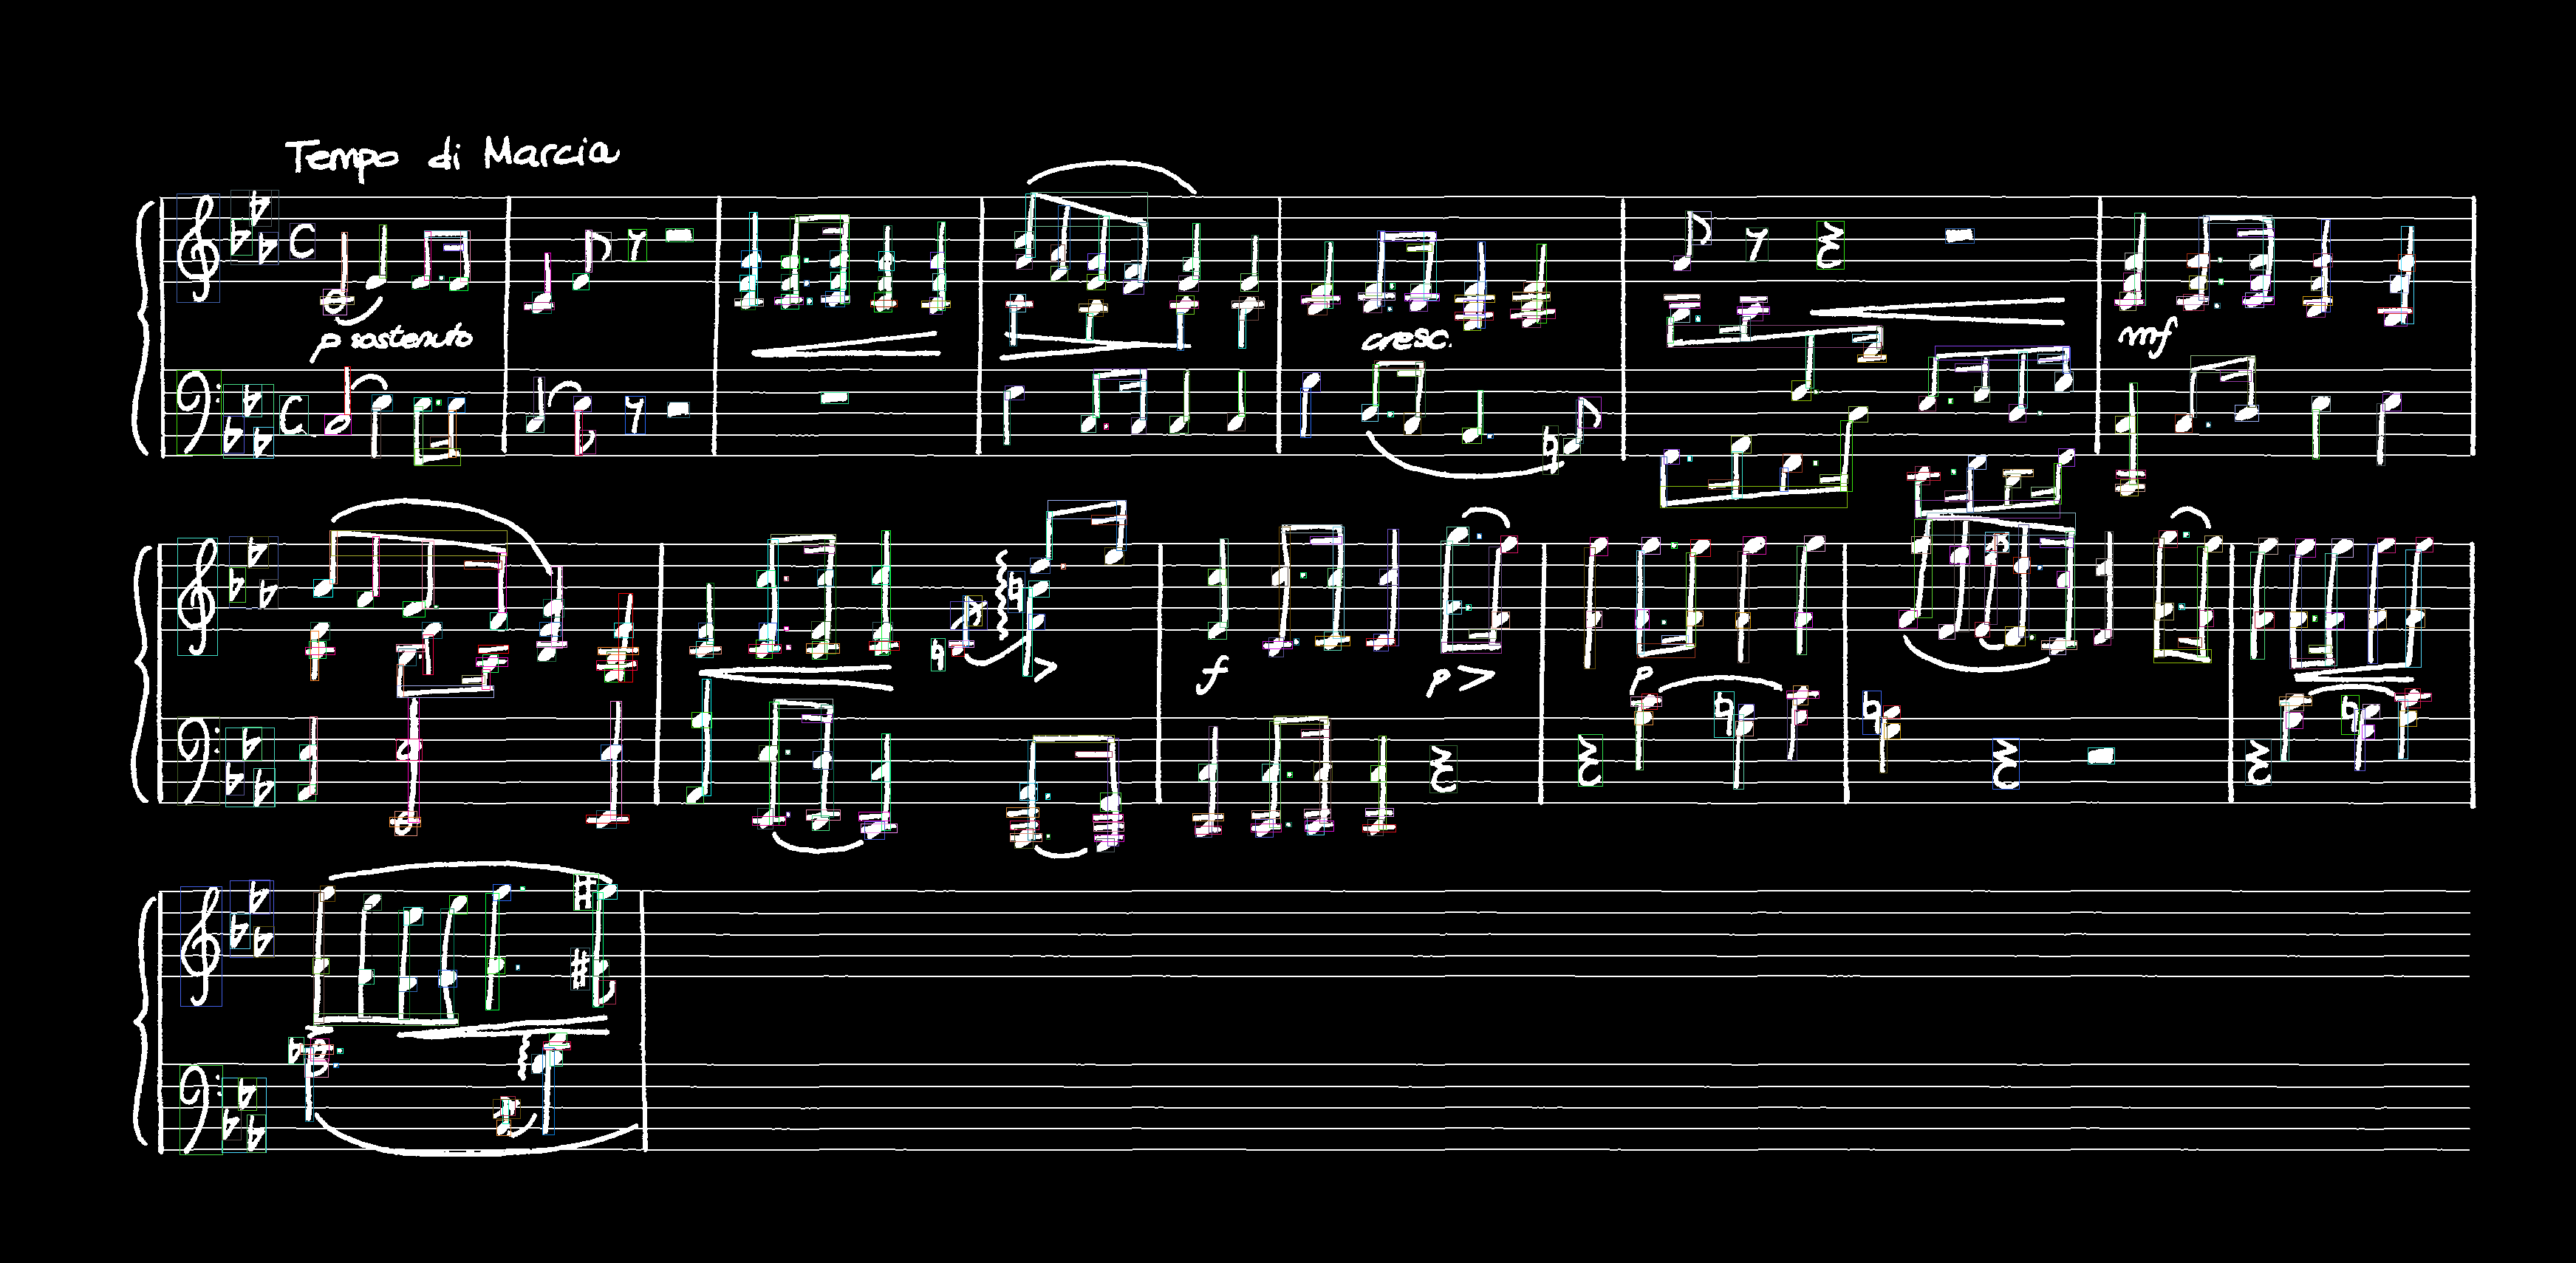

In [6]:
sample_im, sample_ann = dataset[0]
sample_boxes = sample_ann['boxes']

sample_im = (255*sample_im).type(torch.ByteTensor)

from torchvision.utils import draw_bounding_boxes


sample_im_with_bounding_boxes = draw_bounding_boxes(sample_im, sample_boxes)

sample_im_with_bounding_boxes.shape
Image.fromarray(np.moveaxis(sample_im_with_bounding_boxes.numpy(), 0, -1))

### Model

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.anchor_utils import AnchorGenerator

# Pretrained model
# [0.12, 0.24, 0.91, 4.97] - standard reduced symbols
# [0.34, 0.6, 0.88, 1.21] - pitch info only
def get_faster_rcnn_with_n_classes(n: int):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, trainable_backbone_layers=5)

  in_features = model.roi_heads.box_predictor.cls_score.in_features

  model.roi_heads.detections_per_img = 400

  aspects = (0.38, 0.75, 1.14)
  anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
  aspect_ratios = (aspects,) * len(anchor_sizes)
  rpn_anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)

  model.rpn.anchor_generator = rpn_anchor_generator

  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, n)

  return model

In [8]:
from datasets import models
aspects = (0.12, 0.24, 0.91, 4.97)

#model = models.muscima_fpn_model(
#    len(dataset.label_list) + 1,
#    backbone='resnet50',
#    aspects=aspects)

In [9]:
label_list_pitch_only = ['noteheadFull', 'noteheadHalf', 'noteheadWhole', 'accidentalSharp', 'accidentalFlat', 'accidentalNatural',
                    'gCflef', 'fClef', 'cClef']

#model = get_faster_rcnn_with_n_classes(len(label_list_pitch_only) + 1)
#model = models.get_conv_next(num_classes=len(label_list_pitch_only) + 1)

In [10]:
label_list_pitch_only = None
aspects = (0.12, 0.24, 0.91, 4.97)

#model = get_faster_rcnn_with_n_classes(len(dataset.label_list) + 1)
#model = models.get_conv_next(num_classes=len(dataset.label_list) + 1)
model = models.muscima_fpn_model(num_classes=(len(dataset.label_list) + 1),
                                backbone='resnet50',
                                aspects=aspects,)

In [10]:
model = torch.load("checkpoint.pt")

In [11]:
# Test
from datasets import models
#images, targets = next(iter(dataloader))

#images = list(image for image in images)
#targets = [{k: v for k, v in t.items()} for t in targets]
#output = model(images, targets)
#model = models.get_conv_next()

model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x) 

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [13]:
dataset = MuscimaObjects.MuscimaObjects(muscimaroot, label_list_pitch_only, transforms=get_transform(train=True))
dataset_test = MuscimaObjects.MuscimaObjects(muscimaroot, label_list_pitch_only, transforms=get_transform(train=False))

#splits
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-40])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-40:])

print(len(dataset))
print(len(dataset_test))

#dataloaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

100
40


In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

# optimizer
params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.0005)

# learning rate 10x reduction every three epocs
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
#lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=5, threshold=0.01)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
#
total_trainable_params = 0
for p in params:
    num = np.prod(np.asarray(p.shape))
    #print(num)
    total_trainable_params += num
print("Total trainable parameters: ", total_trainable_params)

Total trainable parameters:  41556696


In [15]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 100

run_training_and_validation = True

if run_training_and_validation:
  for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_metrics = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # evaluate on the test dataset
    val_metrics = evaluate(model, data_loader_test, device=device)
    # update the learning rate
    lr_scheduler.step()
    # write metrics to file
    

Epoch: [0]  [  0/100]  eta: 0:04:21  lr: 0.000011  loss: 1.2706 (1.2706)  loss_classifier: 0.5536 (0.5536)  loss_box_reg: 0.0779 (0.0779)  loss_objectness: 0.1763 (0.1763)  loss_rpn_box_reg: 0.4627 (0.4627)  time: 2.6119  data: 0.4768  max mem: 2178
Epoch: [0]  [ 10/100]  eta: 0:01:13  lr: 0.000112  loss: 1.2874 (1.3117)  loss_classifier: 0.6594 (0.6275)  loss_box_reg: 0.0910 (0.1184)  loss_objectness: 0.1497 (0.1435)  loss_rpn_box_reg: 0.4204 (0.4224)  time: 0.8187  data: 0.3157  max mem: 5134
Epoch: [0]  [ 20/100]  eta: 0:00:58  lr: 0.000213  loss: 1.0314 (1.1306)  loss_classifier: 0.2957 (0.4495)  loss_box_reg: 0.1566 (0.1724)  loss_objectness: 0.1481 (0.1430)  loss_rpn_box_reg: 0.3451 (0.3658)  time: 0.6381  data: 0.2971  max mem: 5134
Epoch: [0]  [ 30/100]  eta: 0:00:48  lr: 0.000314  loss: 0.8318 (1.0415)  loss_classifier: 0.1975 (0.3647)  loss_box_reg: 0.2847 (0.2332)  loss_objectness: 0.1076 (0.1300)  loss_rpn_box_reg: 0.2338 (0.3137)  time: 0.6201  data: 0.2773  max mem: 5134


Epoch: [2]  [  0/100]  eta: 0:01:08  lr: 0.000960  loss: 0.8613 (0.8613)  loss_classifier: 0.2015 (0.2015)  loss_box_reg: 0.3389 (0.3389)  loss_objectness: 0.1604 (0.1604)  loss_rpn_box_reg: 0.1605 (0.1605)  time: 0.6865  data: 0.3512  max mem: 5159
Epoch: [2]  [ 10/100]  eta: 0:00:56  lr: 0.000960  loss: 0.8571 (0.8506)  loss_classifier: 0.1784 (0.1678)  loss_box_reg: 0.3497 (0.3618)  loss_objectness: 0.1082 (0.1146)  loss_rpn_box_reg: 0.1960 (0.2064)  time: 0.6258  data: 0.2787  max mem: 5159
Epoch: [2]  [ 20/100]  eta: 0:00:49  lr: 0.000960  loss: 0.7922 (0.8311)  loss_classifier: 0.1350 (0.1544)  loss_box_reg: 0.3289 (0.3552)  loss_objectness: 0.1037 (0.1073)  loss_rpn_box_reg: 0.1960 (0.2141)  time: 0.6128  data: 0.2727  max mem: 5159
Epoch: [2]  [ 30/100]  eta: 0:00:42  lr: 0.000960  loss: 0.7573 (0.7999)  loss_classifier: 0.1262 (0.1451)  loss_box_reg: 0.3289 (0.3500)  loss_objectness: 0.0926 (0.1042)  loss_rpn_box_reg: 0.1785 (0.2006)  time: 0.5930  data: 0.2642  max mem: 5159


Epoch: [4]  [  0/100]  eta: 0:01:15  lr: 0.000922  loss: 0.7595 (0.7595)  loss_classifier: 0.1486 (0.1486)  loss_box_reg: 0.3752 (0.3752)  loss_objectness: 0.0804 (0.0804)  loss_rpn_box_reg: 0.1553 (0.1553)  time: 0.7538  data: 0.3889  max mem: 5159
Epoch: [4]  [ 10/100]  eta: 0:00:52  lr: 0.000922  loss: 0.6792 (0.7151)  loss_classifier: 0.1310 (0.1442)  loss_box_reg: 0.3013 (0.3179)  loss_objectness: 0.1018 (0.0960)  loss_rpn_box_reg: 0.1522 (0.1570)  time: 0.5824  data: 0.2401  max mem: 5159
Epoch: [4]  [ 20/100]  eta: 0:00:47  lr: 0.000922  loss: 0.7212 (0.7899)  loss_classifier: 0.1310 (0.1669)  loss_box_reg: 0.3133 (0.3466)  loss_objectness: 0.0910 (0.0940)  loss_rpn_box_reg: 0.1562 (0.1824)  time: 0.5901  data: 0.2539  max mem: 5159
Epoch: [4]  [ 30/100]  eta: 0:00:42  lr: 0.000922  loss: 0.8164 (0.8085)  loss_classifier: 0.1460 (0.1710)  loss_box_reg: 0.3722 (0.3546)  loss_objectness: 0.0838 (0.0961)  loss_rpn_box_reg: 0.1756 (0.1867)  time: 0.6228  data: 0.2838  max mem: 5159


Epoch: [6]  [  0/100]  eta: 0:00:55  lr: 0.000886  loss: 1.1675 (1.1675)  loss_classifier: 0.2779 (0.2779)  loss_box_reg: 0.2129 (0.2129)  loss_objectness: 0.3786 (0.3786)  loss_rpn_box_reg: 0.2981 (0.2981)  time: 0.5578  data: 0.2951  max mem: 5159
Epoch: [6]  [ 10/100]  eta: 0:00:55  lr: 0.000886  loss: 1.2214 (1.2644)  loss_classifier: 0.3235 (0.3583)  loss_box_reg: 0.3771 (0.3463)  loss_objectness: 0.2201 (0.2318)  loss_rpn_box_reg: 0.2982 (0.3280)  time: 0.6167  data: 0.2743  max mem: 5159
Epoch: [6]  [ 20/100]  eta: 0:00:48  lr: 0.000886  loss: 1.2184 (1.2922)  loss_classifier: 0.3181 (0.3522)  loss_box_reg: 0.3909 (0.3914)  loss_objectness: 0.2187 (0.2383)  loss_rpn_box_reg: 0.3043 (0.3102)  time: 0.6068  data: 0.2678  max mem: 5159
Epoch: [6]  [ 30/100]  eta: 0:00:42  lr: 0.000886  loss: 1.2101 (1.2592)  loss_classifier: 0.2705 (0.3357)  loss_box_reg: 0.3957 (0.3963)  loss_objectness: 0.2262 (0.2325)  loss_rpn_box_reg: 0.2524 (0.2947)  time: 0.6006  data: 0.2713  max mem: 5159


Epoch: [8]  [  0/100]  eta: 0:00:59  lr: 0.000851  loss: 1.9571 (1.9571)  loss_classifier: 1.0435 (1.0435)  loss_box_reg: 0.2692 (0.2692)  loss_objectness: 0.2216 (0.2216)  loss_rpn_box_reg: 0.4228 (0.4228)  time: 0.5955  data: 0.2672  max mem: 5159
Epoch: [8]  [ 10/100]  eta: 0:00:55  lr: 0.000851  loss: 1.7090 (1.7031)  loss_classifier: 0.6619 (0.7278)  loss_box_reg: 0.2805 (0.3096)  loss_objectness: 0.2560 (0.2597)  loss_rpn_box_reg: 0.4228 (0.4060)  time: 0.6218  data: 0.2853  max mem: 5159
Epoch: [8]  [ 20/100]  eta: 0:00:48  lr: 0.000851  loss: 1.3783 (1.4533)  loss_classifier: 0.4490 (0.5463)  loss_box_reg: 0.2373 (0.2834)  loss_objectness: 0.2546 (0.2569)  loss_rpn_box_reg: 0.3524 (0.3667)  time: 0.6028  data: 0.2652  max mem: 5159
Epoch: [8]  [ 30/100]  eta: 0:00:42  lr: 0.000851  loss: 1.1954 (1.3632)  loss_classifier: 0.3112 (0.4756)  loss_box_reg: 0.2451 (0.2836)  loss_objectness: 0.2483 (0.2527)  loss_rpn_box_reg: 0.3073 (0.3513)  time: 0.5890  data: 0.2536  max mem: 5159


Epoch: [10]  [  0/100]  eta: 0:01:02  lr: 0.000817  loss: 1.0038 (1.0038)  loss_classifier: 0.2408 (0.2408)  loss_box_reg: 0.4037 (0.4037)  loss_objectness: 0.1206 (0.1206)  loss_rpn_box_reg: 0.2387 (0.2387)  time: 0.6205  data: 0.2607  max mem: 5159
Epoch: [10]  [ 10/100]  eta: 0:00:53  lr: 0.000817  loss: 1.0041 (1.0177)  loss_classifier: 0.2115 (0.2129)  loss_box_reg: 0.4191 (0.4374)  loss_objectness: 0.1344 (0.1385)  loss_rpn_box_reg: 0.2034 (0.2289)  time: 0.5994  data: 0.2758  max mem: 5159
Epoch: [10]  [ 20/100]  eta: 0:00:46  lr: 0.000817  loss: 1.0673 (1.0726)  loss_classifier: 0.2248 (0.2579)  loss_box_reg: 0.4191 (0.4079)  loss_objectness: 0.1407 (0.1484)  loss_rpn_box_reg: 0.2034 (0.2584)  time: 0.5778  data: 0.2575  max mem: 5159
Epoch: [10]  [ 30/100]  eta: 0:00:40  lr: 0.000817  loss: 1.1123 (1.0922)  loss_classifier: 0.2437 (0.2696)  loss_box_reg: 0.4285 (0.4142)  loss_objectness: 0.1447 (0.1501)  loss_rpn_box_reg: 0.2289 (0.2584)  time: 0.5601  data: 0.2403  max mem: 5

Epoch: [12]  [  0/100]  eta: 0:01:05  lr: 0.000785  loss: 1.1708 (1.1708)  loss_classifier: 0.4133 (0.4133)  loss_box_reg: 0.4229 (0.4229)  loss_objectness: 0.1297 (0.1297)  loss_rpn_box_reg: 0.2049 (0.2049)  time: 0.6545  data: 0.3131  max mem: 5159
Epoch: [12]  [ 10/100]  eta: 0:00:53  lr: 0.000785  loss: 0.8530 (0.9043)  loss_classifier: 0.1627 (0.2047)  loss_box_reg: 0.3739 (0.3507)  loss_objectness: 0.1283 (0.1215)  loss_rpn_box_reg: 0.2049 (0.2274)  time: 0.5930  data: 0.2626  max mem: 5159
Epoch: [12]  [ 20/100]  eta: 0:00:46  lr: 0.000785  loss: 0.8530 (0.9062)  loss_classifier: 0.1627 (0.2016)  loss_box_reg: 0.3690 (0.3653)  loss_objectness: 0.1182 (0.1179)  loss_rpn_box_reg: 0.1927 (0.2214)  time: 0.5764  data: 0.2537  max mem: 5159
Epoch: [12]  [ 30/100]  eta: 0:00:41  lr: 0.000785  loss: 0.8224 (0.8973)  loss_classifier: 0.1643 (0.1918)  loss_box_reg: 0.3834 (0.3722)  loss_objectness: 0.1094 (0.1211)  loss_rpn_box_reg: 0.1907 (0.2121)  time: 0.5862  data: 0.2560  max mem: 5

Epoch: [14]  [  0/100]  eta: 0:01:02  lr: 0.000754  loss: 0.7540 (0.7540)  loss_classifier: 0.1554 (0.1554)  loss_box_reg: 0.3392 (0.3392)  loss_objectness: 0.0661 (0.0661)  loss_rpn_box_reg: 0.1933 (0.1933)  time: 0.6206  data: 0.2768  max mem: 5159
Epoch: [14]  [ 10/100]  eta: 0:00:53  lr: 0.000754  loss: 0.7876 (0.8262)  loss_classifier: 0.1584 (0.1539)  loss_box_reg: 0.3416 (0.3614)  loss_objectness: 0.0986 (0.0967)  loss_rpn_box_reg: 0.2064 (0.2142)  time: 0.5931  data: 0.2567  max mem: 5159
Epoch: [14]  [ 20/100]  eta: 0:00:45  lr: 0.000754  loss: 0.8438 (0.8644)  loss_classifier: 0.1770 (0.1725)  loss_box_reg: 0.3439 (0.3605)  loss_objectness: 0.1063 (0.1051)  loss_rpn_box_reg: 0.2142 (0.2263)  time: 0.5653  data: 0.2400  max mem: 5159
Epoch: [14]  [ 30/100]  eta: 0:00:40  lr: 0.000754  loss: 0.8265 (0.8440)  loss_classifier: 0.1780 (0.1710)  loss_box_reg: 0.3474 (0.3561)  loss_objectness: 0.1063 (0.1045)  loss_rpn_box_reg: 0.1841 (0.2123)  time: 0.5617  data: 0.2324  max mem: 5

Epoch: [16]  [  0/100]  eta: 0:00:58  lr: 0.000724  loss: 0.5792 (0.5792)  loss_classifier: 0.0861 (0.0861)  loss_box_reg: 0.2377 (0.2377)  loss_objectness: 0.1054 (0.1054)  loss_rpn_box_reg: 0.1501 (0.1501)  time: 0.5894  data: 0.2825  max mem: 5159
Epoch: [16]  [ 10/100]  eta: 0:00:52  lr: 0.000724  loss: 0.7307 (0.7365)  loss_classifier: 0.1490 (0.1323)  loss_box_reg: 0.3328 (0.3287)  loss_objectness: 0.0757 (0.0808)  loss_rpn_box_reg: 0.1808 (0.1947)  time: 0.5856  data: 0.2672  max mem: 5159
Epoch: [16]  [ 20/100]  eta: 0:00:48  lr: 0.000724  loss: 0.6982 (0.7233)  loss_classifier: 0.1199 (0.1348)  loss_box_reg: 0.3227 (0.3226)  loss_objectness: 0.0753 (0.0816)  loss_rpn_box_reg: 0.1678 (0.1843)  time: 0.6069  data: 0.2638  max mem: 5159
Epoch: [16]  [ 30/100]  eta: 0:00:42  lr: 0.000724  loss: 0.6746 (0.7341)  loss_classifier: 0.1336 (0.1417)  loss_box_reg: 0.3108 (0.3218)  loss_objectness: 0.0894 (0.0878)  loss_rpn_box_reg: 0.1558 (0.1828)  time: 0.6183  data: 0.2607  max mem: 5

Epoch: [18]  [  0/100]  eta: 0:00:45  lr: 0.000695  loss: 0.6340 (0.6340)  loss_classifier: 0.1065 (0.1065)  loss_box_reg: 0.3130 (0.3130)  loss_objectness: 0.1049 (0.1049)  loss_rpn_box_reg: 0.1096 (0.1096)  time: 0.4505  data: 0.1737  max mem: 5159
Epoch: [18]  [ 10/100]  eta: 0:00:53  lr: 0.000695  loss: 0.5978 (0.6694)  loss_classifier: 0.1152 (0.1225)  loss_box_reg: 0.2765 (0.2980)  loss_objectness: 0.0680 (0.0914)  loss_rpn_box_reg: 0.1279 (0.1575)  time: 0.5987  data: 0.2557  max mem: 5159
Epoch: [18]  [ 20/100]  eta: 0:00:47  lr: 0.000695  loss: 0.6606 (0.7118)  loss_classifier: 0.1257 (0.1328)  loss_box_reg: 0.2765 (0.3195)  loss_objectness: 0.0806 (0.0910)  loss_rpn_box_reg: 0.1629 (0.1686)  time: 0.6048  data: 0.2600  max mem: 5159
Epoch: [18]  [ 30/100]  eta: 0:00:41  lr: 0.000695  loss: 0.7800 (0.7343)  loss_classifier: 0.1416 (0.1403)  loss_box_reg: 0.3461 (0.3168)  loss_objectness: 0.0924 (0.0943)  loss_rpn_box_reg: 0.1882 (0.1828)  time: 0.5939  data: 0.2630  max mem: 5

Epoch: [20]  [  0/100]  eta: 0:01:01  lr: 0.000668  loss: 0.7274 (0.7274)  loss_classifier: 0.0956 (0.0956)  loss_box_reg: 0.2468 (0.2468)  loss_objectness: 0.1016 (0.1016)  loss_rpn_box_reg: 0.2834 (0.2834)  time: 0.6157  data: 0.2666  max mem: 5159
Epoch: [20]  [ 10/100]  eta: 0:00:51  lr: 0.000668  loss: 0.6352 (0.6525)  loss_classifier: 0.1060 (0.1164)  loss_box_reg: 0.2529 (0.2893)  loss_objectness: 0.0981 (0.0909)  loss_rpn_box_reg: 0.1453 (0.1560)  time: 0.5764  data: 0.2480  max mem: 5159
Epoch: [20]  [ 20/100]  eta: 0:00:46  lr: 0.000668  loss: 0.6604 (0.6740)  loss_classifier: 0.1072 (0.1305)  loss_box_reg: 0.2716 (0.2930)  loss_objectness: 0.0799 (0.0830)  loss_rpn_box_reg: 0.1538 (0.1675)  time: 0.5832  data: 0.2632  max mem: 5159
Epoch: [20]  [ 30/100]  eta: 0:00:41  lr: 0.000668  loss: 0.6907 (0.6844)  loss_classifier: 0.1310 (0.1332)  loss_box_reg: 0.2675 (0.2945)  loss_objectness: 0.0777 (0.0836)  loss_rpn_box_reg: 0.1796 (0.1730)  time: 0.6005  data: 0.2764  max mem: 5

Epoch: [22]  [  0/100]  eta: 0:01:06  lr: 0.000641  loss: 0.6116 (0.6116)  loss_classifier: 0.1298 (0.1298)  loss_box_reg: 0.2483 (0.2483)  loss_objectness: 0.1063 (0.1063)  loss_rpn_box_reg: 0.1272 (0.1272)  time: 0.6609  data: 0.2873  max mem: 5159
Epoch: [22]  [ 10/100]  eta: 0:00:54  lr: 0.000641  loss: 0.6701 (0.6752)  loss_classifier: 0.1155 (0.1158)  loss_box_reg: 0.2719 (0.2822)  loss_objectness: 0.0969 (0.0989)  loss_rpn_box_reg: 0.1717 (0.1784)  time: 0.6019  data: 0.2663  max mem: 5159
Epoch: [22]  [ 20/100]  eta: 0:00:48  lr: 0.000641  loss: 0.6416 (0.6453)  loss_classifier: 0.1076 (0.1140)  loss_box_reg: 0.2714 (0.2702)  loss_objectness: 0.0870 (0.0906)  loss_rpn_box_reg: 0.1650 (0.1704)  time: 0.6005  data: 0.2658  max mem: 5159
Epoch: [22]  [ 30/100]  eta: 0:00:42  lr: 0.000641  loss: 0.5915 (0.6435)  loss_classifier: 0.0987 (0.1185)  loss_box_reg: 0.2391 (0.2705)  loss_objectness: 0.0746 (0.0863)  loss_rpn_box_reg: 0.1434 (0.1682)  time: 0.5991  data: 0.2624  max mem: 5

Epoch: [24]  [  0/100]  eta: 0:00:59  lr: 0.000616  loss: 0.5568 (0.5568)  loss_classifier: 0.0796 (0.0796)  loss_box_reg: 0.2937 (0.2937)  loss_objectness: 0.0528 (0.0528)  loss_rpn_box_reg: 0.1307 (0.1307)  time: 0.5994  data: 0.2970  max mem: 5159
Epoch: [24]  [ 10/100]  eta: 0:00:55  lr: 0.000616  loss: 0.6466 (0.6266)  loss_classifier: 0.1418 (0.1305)  loss_box_reg: 0.2576 (0.2580)  loss_objectness: 0.0794 (0.0894)  loss_rpn_box_reg: 0.1435 (0.1488)  time: 0.6186  data: 0.2764  max mem: 5159
Epoch: [24]  [ 20/100]  eta: 0:00:47  lr: 0.000616  loss: 0.6196 (0.6101)  loss_classifier: 0.1089 (0.1146)  loss_box_reg: 0.2558 (0.2641)  loss_objectness: 0.0833 (0.0858)  loss_rpn_box_reg: 0.1434 (0.1456)  time: 0.5893  data: 0.2557  max mem: 5159
Epoch: [24]  [ 30/100]  eta: 0:00:41  lr: 0.000616  loss: 0.6048 (0.6011)  loss_classifier: 0.0984 (0.1119)  loss_box_reg: 0.2494 (0.2607)  loss_objectness: 0.0703 (0.0794)  loss_rpn_box_reg: 0.1433 (0.1490)  time: 0.5793  data: 0.2492  max mem: 5

Epoch: [26]  [  0/100]  eta: 0:00:57  lr: 0.000591  loss: 0.4368 (0.4368)  loss_classifier: 0.0772 (0.0772)  loss_box_reg: 0.1713 (0.1713)  loss_objectness: 0.0795 (0.0795)  loss_rpn_box_reg: 0.1089 (0.1089)  time: 0.5718  data: 0.1997  max mem: 5159
Epoch: [26]  [ 10/100]  eta: 0:00:53  lr: 0.000591  loss: 0.6195 (0.5801)  loss_classifier: 0.1142 (0.1085)  loss_box_reg: 0.2413 (0.2513)  loss_objectness: 0.0795 (0.0802)  loss_rpn_box_reg: 0.1471 (0.1402)  time: 0.5981  data: 0.2564  max mem: 5159
Epoch: [26]  [ 20/100]  eta: 0:00:46  lr: 0.000591  loss: 0.5690 (0.5776)  loss_classifier: 0.1028 (0.1021)  loss_box_reg: 0.2413 (0.2497)  loss_objectness: 0.0782 (0.0781)  loss_rpn_box_reg: 0.1394 (0.1477)  time: 0.5848  data: 0.2587  max mem: 5159
Epoch: [26]  [ 30/100]  eta: 0:00:40  lr: 0.000591  loss: 0.5594 (0.5733)  loss_classifier: 0.0890 (0.0974)  loss_box_reg: 0.2426 (0.2492)  loss_objectness: 0.0592 (0.0757)  loss_rpn_box_reg: 0.1389 (0.1510)  time: 0.5706  data: 0.2490  max mem: 5

Epoch: [28]  [  0/100]  eta: 0:01:05  lr: 0.000568  loss: 0.5952 (0.5952)  loss_classifier: 0.1140 (0.1140)  loss_box_reg: 0.2547 (0.2547)  loss_objectness: 0.0755 (0.0755)  loss_rpn_box_reg: 0.1510 (0.1510)  time: 0.6568  data: 0.2839  max mem: 5159
Epoch: [28]  [ 10/100]  eta: 0:00:48  lr: 0.000568  loss: 0.5948 (0.5889)  loss_classifier: 0.0987 (0.0924)  loss_box_reg: 0.2734 (0.2813)  loss_objectness: 0.0553 (0.0627)  loss_rpn_box_reg: 0.1447 (0.1524)  time: 0.5379  data: 0.2269  max mem: 5159
Epoch: [28]  [ 20/100]  eta: 0:00:45  lr: 0.000568  loss: 0.5718 (0.6218)  loss_classifier: 0.0992 (0.1141)  loss_box_reg: 0.2659 (0.2843)  loss_objectness: 0.0578 (0.0657)  loss_rpn_box_reg: 0.1447 (0.1577)  time: 0.5593  data: 0.2389  max mem: 5159
Epoch: [28]  [ 30/100]  eta: 0:00:40  lr: 0.000568  loss: 0.5822 (0.6208)  loss_classifier: 0.1143 (0.1149)  loss_box_reg: 0.2528 (0.2745)  loss_objectness: 0.0811 (0.0752)  loss_rpn_box_reg: 0.1456 (0.1563)  time: 0.5923  data: 0.2530  max mem: 5

Epoch: [30]  [  0/100]  eta: 0:00:57  lr: 0.000545  loss: 0.5743 (0.5743)  loss_classifier: 0.0648 (0.0648)  loss_box_reg: 0.3463 (0.3463)  loss_objectness: 0.0682 (0.0682)  loss_rpn_box_reg: 0.0950 (0.0950)  time: 0.5746  data: 0.1919  max mem: 5159
Epoch: [30]  [ 10/100]  eta: 0:00:54  lr: 0.000545  loss: 0.5061 (0.5054)  loss_classifier: 0.0759 (0.0785)  loss_box_reg: 0.2217 (0.2250)  loss_objectness: 0.0628 (0.0643)  loss_rpn_box_reg: 0.1296 (0.1376)  time: 0.6015  data: 0.2492  max mem: 5159
Epoch: [30]  [ 20/100]  eta: 0:00:47  lr: 0.000545  loss: 0.5061 (0.5304)  loss_classifier: 0.0815 (0.0886)  loss_box_reg: 0.2217 (0.2333)  loss_objectness: 0.0693 (0.0720)  loss_rpn_box_reg: 0.1296 (0.1364)  time: 0.5962  data: 0.2538  max mem: 5159
Epoch: [30]  [ 30/100]  eta: 0:00:41  lr: 0.000545  loss: 0.5254 (0.5341)  loss_classifier: 0.0958 (0.0988)  loss_box_reg: 0.2228 (0.2307)  loss_objectness: 0.0693 (0.0705)  loss_rpn_box_reg: 0.1256 (0.1342)  time: 0.5968  data: 0.2590  max mem: 5

Epoch: [32]  [  0/100]  eta: 0:01:04  lr: 0.000524  loss: 0.5579 (0.5579)  loss_classifier: 0.0919 (0.0919)  loss_box_reg: 0.2691 (0.2691)  loss_objectness: 0.0654 (0.0654)  loss_rpn_box_reg: 0.1315 (0.1315)  time: 0.6434  data: 0.3073  max mem: 5159
Epoch: [32]  [ 10/100]  eta: 0:00:53  lr: 0.000524  loss: 0.5236 (0.5244)  loss_classifier: 0.0779 (0.0845)  loss_box_reg: 0.2198 (0.2319)  loss_objectness: 0.0642 (0.0590)  loss_rpn_box_reg: 0.1336 (0.1490)  time: 0.5916  data: 0.2567  max mem: 5159
Epoch: [32]  [ 20/100]  eta: 0:00:46  lr: 0.000524  loss: 0.5236 (0.5182)  loss_classifier: 0.0835 (0.0905)  loss_box_reg: 0.2180 (0.2273)  loss_objectness: 0.0511 (0.0602)  loss_rpn_box_reg: 0.1317 (0.1402)  time: 0.5823  data: 0.2525  max mem: 5159
Epoch: [32]  [ 30/100]  eta: 0:00:41  lr: 0.000524  loss: 0.5382 (0.5232)  loss_classifier: 0.0846 (0.0952)  loss_box_reg: 0.2180 (0.2256)  loss_objectness: 0.0640 (0.0629)  loss_rpn_box_reg: 0.1292 (0.1395)  time: 0.5843  data: 0.2566  max mem: 5

Epoch: [34]  [  0/100]  eta: 0:01:06  lr: 0.000503  loss: 0.3887 (0.3887)  loss_classifier: 0.0891 (0.0891)  loss_box_reg: 0.1382 (0.1382)  loss_objectness: 0.0696 (0.0696)  loss_rpn_box_reg: 0.0918 (0.0918)  time: 0.6641  data: 0.3331  max mem: 5159
Epoch: [34]  [ 10/100]  eta: 0:00:50  lr: 0.000503  loss: 0.4465 (0.4823)  loss_classifier: 0.0818 (0.0919)  loss_box_reg: 0.1811 (0.2005)  loss_objectness: 0.0544 (0.0574)  loss_rpn_box_reg: 0.1160 (0.1324)  time: 0.5662  data: 0.2429  max mem: 5159
Epoch: [34]  [ 20/100]  eta: 0:00:45  lr: 0.000503  loss: 0.4782 (0.4778)  loss_classifier: 0.0818 (0.0866)  loss_box_reg: 0.2041 (0.2065)  loss_objectness: 0.0510 (0.0570)  loss_rpn_box_reg: 0.1183 (0.1276)  time: 0.5649  data: 0.2396  max mem: 5159
Epoch: [34]  [ 30/100]  eta: 0:00:39  lr: 0.000503  loss: 0.4977 (0.5011)  loss_classifier: 0.0865 (0.0915)  loss_box_reg: 0.2196 (0.2166)  loss_objectness: 0.0599 (0.0616)  loss_rpn_box_reg: 0.1202 (0.1313)  time: 0.5678  data: 0.2454  max mem: 5

Epoch: [36]  [  0/100]  eta: 0:01:08  lr: 0.000483  loss: 0.3859 (0.3859)  loss_classifier: 0.0614 (0.0614)  loss_box_reg: 0.1855 (0.1855)  loss_objectness: 0.0180 (0.0180)  loss_rpn_box_reg: 0.1210 (0.1210)  time: 0.6850  data: 0.3230  max mem: 5159
Epoch: [36]  [ 10/100]  eta: 0:00:53  lr: 0.000483  loss: 0.4746 (0.4816)  loss_classifier: 0.0718 (0.0897)  loss_box_reg: 0.1855 (0.2054)  loss_objectness: 0.0722 (0.0647)  loss_rpn_box_reg: 0.1210 (0.1219)  time: 0.5972  data: 0.2587  max mem: 5159
Epoch: [36]  [ 20/100]  eta: 0:00:47  lr: 0.000483  loss: 0.4666 (0.4668)  loss_classifier: 0.0773 (0.0861)  loss_box_reg: 0.2005 (0.2067)  loss_objectness: 0.0701 (0.0643)  loss_rpn_box_reg: 0.0961 (0.1098)  time: 0.5863  data: 0.2564  max mem: 5159
Epoch: [36]  [ 30/100]  eta: 0:00:41  lr: 0.000483  loss: 0.4792 (0.4882)  loss_classifier: 0.0819 (0.0906)  loss_box_reg: 0.2056 (0.2165)  loss_objectness: 0.0685 (0.0662)  loss_rpn_box_reg: 0.1005 (0.1148)  time: 0.5963  data: 0.2550  max mem: 5

Epoch: [38]  [  0/100]  eta: 0:01:01  lr: 0.000464  loss: 0.3459 (0.3459)  loss_classifier: 0.0527 (0.0527)  loss_box_reg: 0.1778 (0.1778)  loss_objectness: 0.0369 (0.0369)  loss_rpn_box_reg: 0.0785 (0.0785)  time: 0.6172  data: 0.2458  max mem: 5159
Epoch: [38]  [ 10/100]  eta: 0:00:55  lr: 0.000464  loss: 0.5360 (0.5328)  loss_classifier: 0.0985 (0.1032)  loss_box_reg: 0.2204 (0.2339)  loss_objectness: 0.0580 (0.0624)  loss_rpn_box_reg: 0.1321 (0.1333)  time: 0.6146  data: 0.2732  max mem: 5159
Epoch: [38]  [ 20/100]  eta: 0:00:47  lr: 0.000464  loss: 0.5186 (0.5163)  loss_classifier: 0.0964 (0.0964)  loss_box_reg: 0.2279 (0.2357)  loss_objectness: 0.0580 (0.0618)  loss_rpn_box_reg: 0.1224 (0.1224)  time: 0.5986  data: 0.2661  max mem: 5159
Epoch: [38]  [ 30/100]  eta: 0:00:42  lr: 0.000464  loss: 0.5064 (0.5092)  loss_classifier: 0.0721 (0.0888)  loss_box_reg: 0.2226 (0.2292)  loss_objectness: 0.0578 (0.0633)  loss_rpn_box_reg: 0.1246 (0.1280)  time: 0.5944  data: 0.2598  max mem: 5

Epoch: [40]  [  0/100]  eta: 0:00:59  lr: 0.000446  loss: 0.5085 (0.5085)  loss_classifier: 0.1036 (0.1036)  loss_box_reg: 0.2260 (0.2260)  loss_objectness: 0.0692 (0.0692)  loss_rpn_box_reg: 0.1098 (0.1098)  time: 0.5942  data: 0.2587  max mem: 5159
Epoch: [40]  [ 10/100]  eta: 0:00:52  lr: 0.000446  loss: 0.5011 (0.4820)  loss_classifier: 0.0697 (0.0879)  loss_box_reg: 0.2173 (0.2248)  loss_objectness: 0.0672 (0.0614)  loss_rpn_box_reg: 0.1063 (0.1079)  time: 0.5803  data: 0.2551  max mem: 5159
Epoch: [40]  [ 20/100]  eta: 0:00:46  lr: 0.000446  loss: 0.4011 (0.4659)  loss_classifier: 0.0697 (0.0879)  loss_box_reg: 0.2017 (0.2160)  loss_objectness: 0.0525 (0.0564)  loss_rpn_box_reg: 0.0984 (0.1056)  time: 0.5861  data: 0.2560  max mem: 5159
Epoch: [40]  [ 30/100]  eta: 0:00:40  lr: 0.000446  loss: 0.4701 (0.4631)  loss_classifier: 0.0697 (0.0806)  loss_box_reg: 0.2017 (0.2170)  loss_objectness: 0.0499 (0.0546)  loss_rpn_box_reg: 0.0984 (0.1108)  time: 0.5812  data: 0.2498  max mem: 5

Epoch: [42]  [  0/100]  eta: 0:00:54  lr: 0.000428  loss: 0.5195 (0.5195)  loss_classifier: 0.1242 (0.1242)  loss_box_reg: 0.2027 (0.2027)  loss_objectness: 0.0684 (0.0684)  loss_rpn_box_reg: 0.1242 (0.1242)  time: 0.5432  data: 0.2416  max mem: 5159
Epoch: [42]  [ 10/100]  eta: 0:00:51  lr: 0.000428  loss: 0.5195 (0.5393)  loss_classifier: 0.0890 (0.0974)  loss_box_reg: 0.2500 (0.2545)  loss_objectness: 0.0410 (0.0420)  loss_rpn_box_reg: 0.1210 (0.1454)  time: 0.5684  data: 0.2373  max mem: 5159
Epoch: [42]  [ 20/100]  eta: 0:00:45  lr: 0.000428  loss: 0.5375 (0.5611)  loss_classifier: 0.0847 (0.0985)  loss_box_reg: 0.2500 (0.2644)  loss_objectness: 0.0481 (0.0592)  loss_rpn_box_reg: 0.1173 (0.1391)  time: 0.5761  data: 0.2462  max mem: 5159
Epoch: [42]  [ 30/100]  eta: 0:00:40  lr: 0.000428  loss: 0.5155 (0.5286)  loss_classifier: 0.0786 (0.0948)  loss_box_reg: 0.2230 (0.2491)  loss_objectness: 0.0545 (0.0550)  loss_rpn_box_reg: 0.1088 (0.1297)  time: 0.5809  data: 0.2544  max mem: 5

Epoch: [44]  [  0/100]  eta: 0:01:04  lr: 0.000411  loss: 0.4436 (0.4436)  loss_classifier: 0.0942 (0.0942)  loss_box_reg: 0.2010 (0.2010)  loss_objectness: 0.0647 (0.0647)  loss_rpn_box_reg: 0.0837 (0.0837)  time: 0.6462  data: 0.2778  max mem: 5159
Epoch: [44]  [ 10/100]  eta: 0:00:51  lr: 0.000411  loss: 0.4343 (0.4508)  loss_classifier: 0.0743 (0.0842)  loss_box_reg: 0.1783 (0.2073)  loss_objectness: 0.0568 (0.0561)  loss_rpn_box_reg: 0.0870 (0.1032)  time: 0.5698  data: 0.2419  max mem: 5159
Epoch: [44]  [ 20/100]  eta: 0:00:46  lr: 0.000411  loss: 0.4585 (0.4720)  loss_classifier: 0.0724 (0.0838)  loss_box_reg: 0.1955 (0.2181)  loss_objectness: 0.0529 (0.0602)  loss_rpn_box_reg: 0.1038 (0.1099)  time: 0.5814  data: 0.2533  max mem: 5159
Epoch: [44]  [ 30/100]  eta: 0:00:41  lr: 0.000411  loss: 0.4032 (0.4480)  loss_classifier: 0.0675 (0.0771)  loss_box_reg: 0.1983 (0.2088)  loss_objectness: 0.0520 (0.0552)  loss_rpn_box_reg: 0.1038 (0.1070)  time: 0.6058  data: 0.2728  max mem: 5

Epoch: [46]  [  0/100]  eta: 0:00:52  lr: 0.000395  loss: 0.7796 (0.7796)  loss_classifier: 0.1272 (0.1272)  loss_box_reg: 0.3475 (0.3475)  loss_objectness: 0.1113 (0.1113)  loss_rpn_box_reg: 0.1936 (0.1936)  time: 0.5259  data: 0.2241  max mem: 5159
Epoch: [46]  [ 10/100]  eta: 0:00:53  lr: 0.000395  loss: 0.4065 (0.4515)  loss_classifier: 0.0734 (0.0790)  loss_box_reg: 0.1992 (0.2171)  loss_objectness: 0.0472 (0.0540)  loss_rpn_box_reg: 0.0889 (0.1014)  time: 0.5935  data: 0.2594  max mem: 5159
Epoch: [46]  [ 20/100]  eta: 0:00:46  lr: 0.000395  loss: 0.4586 (0.4817)  loss_classifier: 0.0770 (0.0856)  loss_box_reg: 0.2158 (0.2228)  loss_objectness: 0.0472 (0.0584)  loss_rpn_box_reg: 0.1026 (0.1150)  time: 0.5841  data: 0.2503  max mem: 5159
Epoch: [46]  [ 30/100]  eta: 0:00:40  lr: 0.000395  loss: 0.5072 (0.4797)  loss_classifier: 0.0848 (0.0862)  loss_box_reg: 0.2158 (0.2222)  loss_objectness: 0.0543 (0.0572)  loss_rpn_box_reg: 0.1109 (0.1142)  time: 0.5805  data: 0.2472  max mem: 5

Epoch: [48]  [  0/100]  eta: 0:00:46  lr: 0.000379  loss: 0.4023 (0.4023)  loss_classifier: 0.0391 (0.0391)  loss_box_reg: 0.2348 (0.2348)  loss_objectness: 0.0110 (0.0110)  loss_rpn_box_reg: 0.1174 (0.1174)  time: 0.4672  data: 0.2007  max mem: 5159
Epoch: [48]  [ 10/100]  eta: 0:00:51  lr: 0.000379  loss: 0.4769 (0.4824)  loss_classifier: 0.0650 (0.0769)  loss_box_reg: 0.2035 (0.2145)  loss_objectness: 0.0627 (0.0652)  loss_rpn_box_reg: 0.1184 (0.1257)  time: 0.5737  data: 0.2485  max mem: 5159
Epoch: [48]  [ 20/100]  eta: 0:00:47  lr: 0.000379  loss: 0.4706 (0.4943)  loss_classifier: 0.0911 (0.0909)  loss_box_reg: 0.2057 (0.2245)  loss_objectness: 0.0485 (0.0629)  loss_rpn_box_reg: 0.1184 (0.1160)  time: 0.5968  data: 0.2662  max mem: 5159
Epoch: [48]  [ 30/100]  eta: 0:00:41  lr: 0.000379  loss: 0.4706 (0.4888)  loss_classifier: 0.0800 (0.0849)  loss_box_reg: 0.2147 (0.2224)  loss_objectness: 0.0472 (0.0618)  loss_rpn_box_reg: 0.1108 (0.1198)  time: 0.6010  data: 0.2604  max mem: 5

Epoch: [50]  [  0/100]  eta: 0:01:01  lr: 0.000364  loss: 0.4637 (0.4637)  loss_classifier: 0.1466 (0.1466)  loss_box_reg: 0.1720 (0.1720)  loss_objectness: 0.0899 (0.0899)  loss_rpn_box_reg: 0.0551 (0.0551)  time: 0.6156  data: 0.3151  max mem: 5159
Epoch: [50]  [ 10/100]  eta: 0:00:53  lr: 0.000364  loss: 0.4499 (0.4389)  loss_classifier: 0.0736 (0.0777)  loss_box_reg: 0.1987 (0.1979)  loss_objectness: 0.0602 (0.0622)  loss_rpn_box_reg: 0.0855 (0.1012)  time: 0.5938  data: 0.2541  max mem: 5159
Epoch: [50]  [ 20/100]  eta: 0:00:46  lr: 0.000364  loss: 0.4681 (0.4726)  loss_classifier: 0.0732 (0.0833)  loss_box_reg: 0.2068 (0.2098)  loss_objectness: 0.0555 (0.0619)  loss_rpn_box_reg: 0.1228 (0.1177)  time: 0.5852  data: 0.2458  max mem: 5159
Epoch: [50]  [ 30/100]  eta: 0:00:41  lr: 0.000364  loss: 0.4863 (0.4759)  loss_classifier: 0.0775 (0.0794)  loss_box_reg: 0.2173 (0.2133)  loss_objectness: 0.0688 (0.0674)  loss_rpn_box_reg: 0.1247 (0.1159)  time: 0.5886  data: 0.2574  max mem: 5

Epoch: [52]  [  0/100]  eta: 0:01:04  lr: 0.000350  loss: 0.5510 (0.5510)  loss_classifier: 0.0845 (0.0845)  loss_box_reg: 0.1817 (0.1817)  loss_objectness: 0.1396 (0.1396)  loss_rpn_box_reg: 0.1451 (0.1451)  time: 0.6479  data: 0.2942  max mem: 5159
Epoch: [52]  [ 10/100]  eta: 0:00:53  lr: 0.000350  loss: 0.4161 (0.4775)  loss_classifier: 0.0831 (0.0874)  loss_box_reg: 0.1969 (0.2165)  loss_objectness: 0.0562 (0.0652)  loss_rpn_box_reg: 0.1106 (0.1084)  time: 0.5913  data: 0.2660  max mem: 5159
Epoch: [52]  [ 20/100]  eta: 0:00:48  lr: 0.000350  loss: 0.4452 (0.4721)  loss_classifier: 0.0812 (0.0904)  loss_box_reg: 0.2079 (0.2144)  loss_objectness: 0.0575 (0.0625)  loss_rpn_box_reg: 0.1010 (0.1048)  time: 0.6098  data: 0.2757  max mem: 5159
Epoch: [52]  [ 30/100]  eta: 0:00:43  lr: 0.000350  loss: 0.4452 (0.4617)  loss_classifier: 0.0748 (0.0856)  loss_box_reg: 0.2033 (0.2129)  loss_objectness: 0.0578 (0.0582)  loss_rpn_box_reg: 0.0973 (0.1049)  time: 0.6275  data: 0.2775  max mem: 5

Epoch: [54]  [  0/100]  eta: 0:00:45  lr: 0.000336  loss: 0.4343 (0.4343)  loss_classifier: 0.0591 (0.0591)  loss_box_reg: 0.2245 (0.2245)  loss_objectness: 0.0589 (0.0589)  loss_rpn_box_reg: 0.0918 (0.0918)  time: 0.4580  data: 0.1948  max mem: 5159
Epoch: [54]  [ 10/100]  eta: 0:00:49  lr: 0.000336  loss: 0.4891 (0.5108)  loss_classifier: 0.0748 (0.0860)  loss_box_reg: 0.2245 (0.2408)  loss_objectness: 0.0552 (0.0524)  loss_rpn_box_reg: 0.1415 (0.1316)  time: 0.5483  data: 0.2253  max mem: 5159
Epoch: [54]  [ 20/100]  eta: 0:00:45  lr: 0.000336  loss: 0.4602 (0.4824)  loss_classifier: 0.0783 (0.0875)  loss_box_reg: 0.2222 (0.2276)  loss_objectness: 0.0461 (0.0486)  loss_rpn_box_reg: 0.1098 (0.1186)  time: 0.5706  data: 0.2349  max mem: 5159
Epoch: [54]  [ 30/100]  eta: 0:00:40  lr: 0.000336  loss: 0.4469 (0.4711)  loss_classifier: 0.0753 (0.0819)  loss_box_reg: 0.2087 (0.2211)  loss_objectness: 0.0461 (0.0522)  loss_rpn_box_reg: 0.1081 (0.1159)  time: 0.5851  data: 0.2489  max mem: 5

Epoch: [56]  [  0/100]  eta: 0:01:11  lr: 0.000323  loss: 0.3881 (0.3881)  loss_classifier: 0.0603 (0.0603)  loss_box_reg: 0.1891 (0.1891)  loss_objectness: 0.0476 (0.0476)  loss_rpn_box_reg: 0.0912 (0.0912)  time: 0.7199  data: 0.3850  max mem: 5159
Epoch: [56]  [ 10/100]  eta: 0:00:57  lr: 0.000323  loss: 0.3816 (0.3954)  loss_classifier: 0.0603 (0.0579)  loss_box_reg: 0.1899 (0.2010)  loss_objectness: 0.0380 (0.0366)  loss_rpn_box_reg: 0.0912 (0.0998)  time: 0.6376  data: 0.2936  max mem: 5159
Epoch: [56]  [ 20/100]  eta: 0:00:49  lr: 0.000323  loss: 0.4025 (0.4350)  loss_classifier: 0.0646 (0.0675)  loss_box_reg: 0.2011 (0.2170)  loss_objectness: 0.0393 (0.0433)  loss_rpn_box_reg: 0.1021 (0.1073)  time: 0.6123  data: 0.2721  max mem: 5159
Epoch: [56]  [ 30/100]  eta: 0:00:41  lr: 0.000323  loss: 0.4300 (0.4231)  loss_classifier: 0.0543 (0.0642)  loss_box_reg: 0.2021 (0.2113)  loss_objectness: 0.0454 (0.0437)  loss_rpn_box_reg: 0.0957 (0.1040)  time: 0.5712  data: 0.2456  max mem: 5

Epoch: [58]  [  0/100]  eta: 0:00:58  lr: 0.000310  loss: 0.3844 (0.3844)  loss_classifier: 0.0538 (0.0538)  loss_box_reg: 0.2128 (0.2128)  loss_objectness: 0.0416 (0.0416)  loss_rpn_box_reg: 0.0762 (0.0762)  time: 0.5867  data: 0.2804  max mem: 5159
Epoch: [58]  [ 10/100]  eta: 0:00:51  lr: 0.000310  loss: 0.3844 (0.3903)  loss_classifier: 0.0538 (0.0561)  loss_box_reg: 0.1758 (0.1862)  loss_objectness: 0.0516 (0.0552)  loss_rpn_box_reg: 0.0669 (0.0927)  time: 0.5674  data: 0.2454  max mem: 5159
Epoch: [58]  [ 20/100]  eta: 0:00:46  lr: 0.000310  loss: 0.4013 (0.4272)  loss_classifier: 0.0567 (0.0698)  loss_box_reg: 0.1938 (0.1946)  loss_objectness: 0.0516 (0.0538)  loss_rpn_box_reg: 0.1020 (0.1089)  time: 0.5761  data: 0.2480  max mem: 5159
Epoch: [58]  [ 30/100]  eta: 0:00:40  lr: 0.000310  loss: 0.4311 (0.4214)  loss_classifier: 0.0627 (0.0666)  loss_box_reg: 0.1929 (0.1942)  loss_objectness: 0.0374 (0.0519)  loss_rpn_box_reg: 0.1096 (0.1087)  time: 0.5761  data: 0.2450  max mem: 5

Epoch: [60]  [  0/100]  eta: 0:00:58  lr: 0.000298  loss: 0.3782 (0.3782)  loss_classifier: 0.0758 (0.0758)  loss_box_reg: 0.1904 (0.1904)  loss_objectness: 0.0210 (0.0210)  loss_rpn_box_reg: 0.0910 (0.0910)  time: 0.5863  data: 0.2839  max mem: 5159
Epoch: [60]  [ 10/100]  eta: 0:00:49  lr: 0.000298  loss: 0.3941 (0.4041)  loss_classifier: 0.0743 (0.0639)  loss_box_reg: 0.2106 (0.2057)  loss_objectness: 0.0360 (0.0417)  loss_rpn_box_reg: 0.0890 (0.0927)  time: 0.5555  data: 0.2429  max mem: 5159
Epoch: [60]  [ 20/100]  eta: 0:00:45  lr: 0.000298  loss: 0.4467 (0.4184)  loss_classifier: 0.0670 (0.0663)  loss_box_reg: 0.1936 (0.1974)  loss_objectness: 0.0537 (0.0547)  loss_rpn_box_reg: 0.0858 (0.1000)  time: 0.5676  data: 0.2472  max mem: 5159
Epoch: [60]  [ 30/100]  eta: 0:00:40  lr: 0.000298  loss: 0.4166 (0.4122)  loss_classifier: 0.0592 (0.0657)  loss_box_reg: 0.1815 (0.1971)  loss_objectness: 0.0508 (0.0511)  loss_rpn_box_reg: 0.0883 (0.0984)  time: 0.5859  data: 0.2516  max mem: 5

Epoch: [62]  [  0/100]  eta: 0:01:07  lr: 0.000286  loss: 0.3803 (0.3803)  loss_classifier: 0.0397 (0.0397)  loss_box_reg: 0.1854 (0.1854)  loss_objectness: 0.0503 (0.0503)  loss_rpn_box_reg: 0.1050 (0.1050)  time: 0.6759  data: 0.3109  max mem: 5159
Epoch: [62]  [ 10/100]  eta: 0:00:54  lr: 0.000286  loss: 0.4095 (0.4144)  loss_classifier: 0.0570 (0.0599)  loss_box_reg: 0.2115 (0.2133)  loss_objectness: 0.0603 (0.0529)  loss_rpn_box_reg: 0.0848 (0.0883)  time: 0.6009  data: 0.2528  max mem: 5159
Epoch: [62]  [ 20/100]  eta: 0:00:48  lr: 0.000286  loss: 0.4142 (0.4161)  loss_classifier: 0.0608 (0.0650)  loss_box_reg: 0.2045 (0.2049)  loss_objectness: 0.0558 (0.0532)  loss_rpn_box_reg: 0.0828 (0.0929)  time: 0.6011  data: 0.2521  max mem: 5159
Epoch: [62]  [ 30/100]  eta: 0:00:41  lr: 0.000286  loss: 0.4262 (0.4095)  loss_classifier: 0.0628 (0.0646)  loss_box_reg: 0.1974 (0.1983)  loss_objectness: 0.0478 (0.0503)  loss_rpn_box_reg: 0.0828 (0.0963)  time: 0.5865  data: 0.2474  max mem: 5

Epoch: [64]  [  0/100]  eta: 0:00:58  lr: 0.000274  loss: 0.3116 (0.3116)  loss_classifier: 0.0503 (0.0503)  loss_box_reg: 0.1409 (0.1409)  loss_objectness: 0.0676 (0.0676)  loss_rpn_box_reg: 0.0528 (0.0528)  time: 0.5827  data: 0.2479  max mem: 5159
Epoch: [64]  [ 10/100]  eta: 0:00:50  lr: 0.000274  loss: 0.4017 (0.4270)  loss_classifier: 0.0552 (0.0601)  loss_box_reg: 0.2063 (0.2064)  loss_objectness: 0.0363 (0.0454)  loss_rpn_box_reg: 0.1039 (0.1151)  time: 0.5662  data: 0.2247  max mem: 5159
Epoch: [64]  [ 20/100]  eta: 0:00:44  lr: 0.000274  loss: 0.4308 (0.4391)  loss_classifier: 0.0638 (0.0662)  loss_box_reg: 0.2118 (0.2178)  loss_objectness: 0.0420 (0.0453)  loss_rpn_box_reg: 0.1039 (0.1099)  time: 0.5609  data: 0.2276  max mem: 5159
Epoch: [64]  [ 30/100]  eta: 0:00:39  lr: 0.000274  loss: 0.4411 (0.4403)  loss_classifier: 0.0653 (0.0680)  loss_box_reg: 0.2118 (0.2154)  loss_objectness: 0.0472 (0.0480)  loss_rpn_box_reg: 0.1003 (0.1089)  time: 0.5742  data: 0.2420  max mem: 5

Epoch: [66]  [  0/100]  eta: 0:00:57  lr: 0.000264  loss: 0.3544 (0.3544)  loss_classifier: 0.0530 (0.0530)  loss_box_reg: 0.1908 (0.1908)  loss_objectness: 0.0448 (0.0448)  loss_rpn_box_reg: 0.0659 (0.0659)  time: 0.5760  data: 0.2017  max mem: 5159
Epoch: [66]  [ 10/100]  eta: 0:00:52  lr: 0.000264  loss: 0.4068 (0.4207)  loss_classifier: 0.0606 (0.0607)  loss_box_reg: 0.1949 (0.1971)  loss_objectness: 0.0448 (0.0533)  loss_rpn_box_reg: 0.1120 (0.1096)  time: 0.5797  data: 0.2462  max mem: 5159
Epoch: [66]  [ 20/100]  eta: 0:00:46  lr: 0.000264  loss: 0.3895 (0.3933)  loss_classifier: 0.0606 (0.0603)  loss_box_reg: 0.1862 (0.1853)  loss_objectness: 0.0308 (0.0454)  loss_rpn_box_reg: 0.0994 (0.1022)  time: 0.5802  data: 0.2473  max mem: 5159
Epoch: [66]  [ 30/100]  eta: 0:00:40  lr: 0.000264  loss: 0.3844 (0.3972)  loss_classifier: 0.0623 (0.0597)  loss_box_reg: 0.1843 (0.1887)  loss_objectness: 0.0444 (0.0485)  loss_rpn_box_reg: 0.0961 (0.1004)  time: 0.5728  data: 0.2397  max mem: 5

Epoch: [68]  [  0/100]  eta: 0:00:59  lr: 0.000253  loss: 0.2458 (0.2458)  loss_classifier: 0.0232 (0.0232)  loss_box_reg: 0.1305 (0.1305)  loss_objectness: 0.0348 (0.0348)  loss_rpn_box_reg: 0.0572 (0.0572)  time: 0.5963  data: 0.2561  max mem: 5159
Epoch: [68]  [ 10/100]  eta: 0:00:50  lr: 0.000253  loss: 0.4267 (0.4051)  loss_classifier: 0.0693 (0.0649)  loss_box_reg: 0.2005 (0.1977)  loss_objectness: 0.0325 (0.0418)  loss_rpn_box_reg: 0.0849 (0.1007)  time: 0.5657  data: 0.2320  max mem: 5159
Epoch: [68]  [ 20/100]  eta: 0:00:45  lr: 0.000253  loss: 0.3977 (0.3901)  loss_classifier: 0.0631 (0.0575)  loss_box_reg: 0.1892 (0.1847)  loss_objectness: 0.0564 (0.0495)  loss_rpn_box_reg: 0.0878 (0.0983)  time: 0.5669  data: 0.2373  max mem: 5159
Epoch: [68]  [ 30/100]  eta: 0:00:39  lr: 0.000253  loss: 0.4002 (0.3953)  loss_classifier: 0.0480 (0.0593)  loss_box_reg: 0.1743 (0.1888)  loss_objectness: 0.0589 (0.0515)  loss_rpn_box_reg: 0.0872 (0.0956)  time: 0.5744  data: 0.2450  max mem: 5

Epoch: [70]  [  0/100]  eta: 0:00:52  lr: 0.000243  loss: 0.3943 (0.3943)  loss_classifier: 0.0362 (0.0362)  loss_box_reg: 0.2120 (0.2120)  loss_objectness: 0.0723 (0.0723)  loss_rpn_box_reg: 0.0739 (0.0739)  time: 0.5291  data: 0.2601  max mem: 5159
Epoch: [70]  [ 10/100]  eta: 0:00:50  lr: 0.000243  loss: 0.3943 (0.4000)  loss_classifier: 0.0535 (0.0649)  loss_box_reg: 0.2012 (0.1912)  loss_objectness: 0.0442 (0.0461)  loss_rpn_box_reg: 0.0834 (0.0979)  time: 0.5665  data: 0.2403  max mem: 5159
Epoch: [70]  [ 20/100]  eta: 0:00:45  lr: 0.000243  loss: 0.3686 (0.3873)  loss_classifier: 0.0579 (0.0621)  loss_box_reg: 0.1781 (0.1882)  loss_objectness: 0.0327 (0.0460)  loss_rpn_box_reg: 0.0782 (0.0909)  time: 0.5727  data: 0.2402  max mem: 5159
Epoch: [70]  [ 30/100]  eta: 0:00:40  lr: 0.000243  loss: 0.3686 (0.3818)  loss_classifier: 0.0568 (0.0579)  loss_box_reg: 0.1768 (0.1856)  loss_objectness: 0.0448 (0.0496)  loss_rpn_box_reg: 0.0806 (0.0887)  time: 0.5774  data: 0.2365  max mem: 5

Epoch: [72]  [  0/100]  eta: 0:01:11  lr: 0.000233  loss: 0.4404 (0.4404)  loss_classifier: 0.0568 (0.0568)  loss_box_reg: 0.1987 (0.1987)  loss_objectness: 0.0731 (0.0731)  loss_rpn_box_reg: 0.1118 (0.1118)  time: 0.7117  data: 0.3248  max mem: 5159
Epoch: [72]  [ 10/100]  eta: 0:00:52  lr: 0.000233  loss: 0.4082 (0.4120)  loss_classifier: 0.0573 (0.0589)  loss_box_reg: 0.1973 (0.1920)  loss_objectness: 0.0516 (0.0543)  loss_rpn_box_reg: 0.1118 (0.1069)  time: 0.5887  data: 0.2345  max mem: 5159
Epoch: [72]  [ 20/100]  eta: 0:00:46  lr: 0.000233  loss: 0.3881 (0.3844)  loss_classifier: 0.0446 (0.0522)  loss_box_reg: 0.1749 (0.1881)  loss_objectness: 0.0451 (0.0503)  loss_rpn_box_reg: 0.0821 (0.0938)  time: 0.5728  data: 0.2245  max mem: 5159
Epoch: [72]  [ 30/100]  eta: 0:00:40  lr: 0.000233  loss: 0.3352 (0.3908)  loss_classifier: 0.0403 (0.0528)  loss_box_reg: 0.1732 (0.1903)  loss_objectness: 0.0366 (0.0516)  loss_rpn_box_reg: 0.0893 (0.0962)  time: 0.5703  data: 0.2278  max mem: 5

Epoch: [74]  [  0/100]  eta: 0:00:57  lr: 0.000224  loss: 0.4887 (0.4887)  loss_classifier: 0.0678 (0.0678)  loss_box_reg: 0.2385 (0.2385)  loss_objectness: 0.0835 (0.0835)  loss_rpn_box_reg: 0.0990 (0.0990)  time: 0.5766  data: 0.2374  max mem: 5159
Epoch: [74]  [ 10/100]  eta: 0:00:52  lr: 0.000224  loss: 0.3788 (0.3651)  loss_classifier: 0.0503 (0.0500)  loss_box_reg: 0.1924 (0.1859)  loss_objectness: 0.0357 (0.0376)  loss_rpn_box_reg: 0.0855 (0.0915)  time: 0.5809  data: 0.2448  max mem: 5159
Epoch: [74]  [ 20/100]  eta: 0:00:45  lr: 0.000224  loss: 0.3788 (0.3852)  loss_classifier: 0.0496 (0.0516)  loss_box_reg: 0.1893 (0.1950)  loss_objectness: 0.0400 (0.0467)  loss_rpn_box_reg: 0.0804 (0.0918)  time: 0.5675  data: 0.2377  max mem: 5159
Epoch: [74]  [ 30/100]  eta: 0:00:39  lr: 0.000224  loss: 0.3731 (0.3823)  loss_classifier: 0.0543 (0.0594)  loss_box_reg: 0.1771 (0.1858)  loss_objectness: 0.0477 (0.0450)  loss_rpn_box_reg: 0.0866 (0.0921)  time: 0.5551  data: 0.2305  max mem: 5

Epoch: [76]  [  0/100]  eta: 0:00:58  lr: 0.000215  loss: 0.2854 (0.2854)  loss_classifier: 0.0495 (0.0495)  loss_box_reg: 0.1510 (0.1510)  loss_objectness: 0.0323 (0.0323)  loss_rpn_box_reg: 0.0527 (0.0527)  time: 0.5846  data: 0.2481  max mem: 5159
Epoch: [76]  [ 10/100]  eta: 0:00:51  lr: 0.000215  loss: 0.3626 (0.3699)  loss_classifier: 0.0551 (0.0559)  loss_box_reg: 0.1757 (0.1878)  loss_objectness: 0.0323 (0.0381)  loss_rpn_box_reg: 0.0835 (0.0881)  time: 0.5678  data: 0.2388  max mem: 5159
Epoch: [76]  [ 20/100]  eta: 0:00:44  lr: 0.000215  loss: 0.3698 (0.3652)  loss_classifier: 0.0549 (0.0567)  loss_box_reg: 0.1757 (0.1833)  loss_objectness: 0.0336 (0.0380)  loss_rpn_box_reg: 0.0810 (0.0872)  time: 0.5545  data: 0.2303  max mem: 5159
Epoch: [76]  [ 30/100]  eta: 0:00:39  lr: 0.000215  loss: 0.3698 (0.3643)  loss_classifier: 0.0549 (0.0563)  loss_box_reg: 0.1756 (0.1793)  loss_objectness: 0.0477 (0.0424)  loss_rpn_box_reg: 0.0791 (0.0863)  time: 0.5598  data: 0.2322  max mem: 5

Epoch: [78]  [  0/100]  eta: 0:01:09  lr: 0.000207  loss: 0.4293 (0.4293)  loss_classifier: 0.0566 (0.0566)  loss_box_reg: 0.1611 (0.1611)  loss_objectness: 0.1178 (0.1178)  loss_rpn_box_reg: 0.0938 (0.0938)  time: 0.6963  data: 0.3408  max mem: 5159
Epoch: [78]  [ 10/100]  eta: 0:00:53  lr: 0.000207  loss: 0.3961 (0.4019)  loss_classifier: 0.0666 (0.0675)  loss_box_reg: 0.1962 (0.1857)  loss_objectness: 0.0645 (0.0616)  loss_rpn_box_reg: 0.0880 (0.0871)  time: 0.5893  data: 0.2463  max mem: 5159
Epoch: [78]  [ 20/100]  eta: 0:00:46  lr: 0.000207  loss: 0.3847 (0.3941)  loss_classifier: 0.0613 (0.0653)  loss_box_reg: 0.1710 (0.1750)  loss_objectness: 0.0418 (0.0534)  loss_rpn_box_reg: 0.0916 (0.1004)  time: 0.5753  data: 0.2412  max mem: 5159
Epoch: [78]  [ 30/100]  eta: 0:00:40  lr: 0.000207  loss: 0.3805 (0.3933)  loss_classifier: 0.0587 (0.0671)  loss_box_reg: 0.1688 (0.1774)  loss_objectness: 0.0332 (0.0483)  loss_rpn_box_reg: 0.0949 (0.1006)  time: 0.5699  data: 0.2403  max mem: 5

Epoch: [80]  [  0/100]  eta: 0:01:12  lr: 0.000199  loss: 0.3243 (0.3243)  loss_classifier: 0.0458 (0.0458)  loss_box_reg: 0.1412 (0.1412)  loss_objectness: 0.0544 (0.0544)  loss_rpn_box_reg: 0.0829 (0.0829)  time: 0.7261  data: 0.3406  max mem: 5159
Epoch: [80]  [ 10/100]  eta: 0:00:56  lr: 0.000199  loss: 0.3364 (0.3444)  loss_classifier: 0.0514 (0.0545)  loss_box_reg: 0.1705 (0.1726)  loss_objectness: 0.0321 (0.0365)  loss_rpn_box_reg: 0.0713 (0.0807)  time: 0.6259  data: 0.2716  max mem: 5159
Epoch: [80]  [ 20/100]  eta: 0:00:46  lr: 0.000199  loss: 0.3359 (0.3384)  loss_classifier: 0.0474 (0.0519)  loss_box_reg: 0.1705 (0.1743)  loss_objectness: 0.0270 (0.0313)  loss_rpn_box_reg: 0.0739 (0.0808)  time: 0.5789  data: 0.2502  max mem: 5159
Epoch: [80]  [ 30/100]  eta: 0:00:40  lr: 0.000199  loss: 0.3226 (0.3396)  loss_classifier: 0.0449 (0.0517)  loss_box_reg: 0.1709 (0.1739)  loss_objectness: 0.0228 (0.0319)  loss_rpn_box_reg: 0.0865 (0.0820)  time: 0.5610  data: 0.2434  max mem: 5

Epoch: [82]  [  0/100]  eta: 0:01:05  lr: 0.000191  loss: 0.3667 (0.3667)  loss_classifier: 0.0692 (0.0692)  loss_box_reg: 0.1524 (0.1524)  loss_objectness: 0.0690 (0.0690)  loss_rpn_box_reg: 0.0761 (0.0761)  time: 0.6521  data: 0.3467  max mem: 5159
Epoch: [82]  [ 10/100]  eta: 0:00:52  lr: 0.000191  loss: 0.3755 (0.3576)  loss_classifier: 0.0497 (0.0525)  loss_box_reg: 0.1827 (0.1761)  loss_objectness: 0.0414 (0.0420)  loss_rpn_box_reg: 0.0947 (0.0870)  time: 0.5847  data: 0.2439  max mem: 5159
Epoch: [82]  [ 20/100]  eta: 0:00:45  lr: 0.000191  loss: 0.3489 (0.3519)  loss_classifier: 0.0471 (0.0506)  loss_box_reg: 0.1723 (0.1761)  loss_objectness: 0.0368 (0.0429)  loss_rpn_box_reg: 0.0908 (0.0823)  time: 0.5684  data: 0.2391  max mem: 5159
Epoch: [82]  [ 30/100]  eta: 0:00:39  lr: 0.000191  loss: 0.3488 (0.3495)  loss_classifier: 0.0482 (0.0494)  loss_box_reg: 0.1632 (0.1768)  loss_objectness: 0.0396 (0.0444)  loss_rpn_box_reg: 0.0614 (0.0790)  time: 0.5562  data: 0.2396  max mem: 5

Epoch: [84]  [  0/100]  eta: 0:01:06  lr: 0.000183  loss: 0.3812 (0.3812)  loss_classifier: 0.0684 (0.0684)  loss_box_reg: 0.1668 (0.1668)  loss_objectness: 0.0408 (0.0408)  loss_rpn_box_reg: 0.1052 (0.1052)  time: 0.6630  data: 0.2785  max mem: 5159
Epoch: [84]  [ 10/100]  eta: 0:00:54  lr: 0.000183  loss: 0.3347 (0.3502)  loss_classifier: 0.0464 (0.0527)  loss_box_reg: 0.1668 (0.1741)  loss_objectness: 0.0408 (0.0468)  loss_rpn_box_reg: 0.0767 (0.0767)  time: 0.6049  data: 0.2706  max mem: 5159
Epoch: [84]  [ 20/100]  eta: 0:00:48  lr: 0.000183  loss: 0.3347 (0.3469)  loss_classifier: 0.0464 (0.0528)  loss_box_reg: 0.1635 (0.1694)  loss_objectness: 0.0364 (0.0424)  loss_rpn_box_reg: 0.0767 (0.0823)  time: 0.5975  data: 0.2646  max mem: 5159
Epoch: [84]  [ 30/100]  eta: 0:00:41  lr: 0.000183  loss: 0.3665 (0.3522)  loss_classifier: 0.0498 (0.0524)  loss_box_reg: 0.1648 (0.1705)  loss_objectness: 0.0326 (0.0422)  loss_rpn_box_reg: 0.1033 (0.0872)  time: 0.5864  data: 0.2513  max mem: 5

Epoch: [86]  [  0/100]  eta: 0:01:06  lr: 0.000176  loss: 0.3863 (0.3863)  loss_classifier: 0.0362 (0.0362)  loss_box_reg: 0.2129 (0.2129)  loss_objectness: 0.0526 (0.0526)  loss_rpn_box_reg: 0.0846 (0.0846)  time: 0.6680  data: 0.3002  max mem: 5159
Epoch: [86]  [ 10/100]  eta: 0:00:51  lr: 0.000176  loss: 0.3597 (0.3544)  loss_classifier: 0.0491 (0.0461)  loss_box_reg: 0.1792 (0.1823)  loss_objectness: 0.0342 (0.0339)  loss_rpn_box_reg: 0.0846 (0.0920)  time: 0.5759  data: 0.2373  max mem: 5159
Epoch: [86]  [ 20/100]  eta: 0:00:45  lr: 0.000176  loss: 0.3357 (0.3378)  loss_classifier: 0.0501 (0.0529)  loss_box_reg: 0.1608 (0.1721)  loss_objectness: 0.0269 (0.0358)  loss_rpn_box_reg: 0.0662 (0.0769)  time: 0.5617  data: 0.2342  max mem: 5159
Epoch: [86]  [ 30/100]  eta: 0:00:41  lr: 0.000176  loss: 0.3474 (0.3488)  loss_classifier: 0.0569 (0.0559)  loss_box_reg: 0.1583 (0.1713)  loss_objectness: 0.0300 (0.0390)  loss_rpn_box_reg: 0.0662 (0.0826)  time: 0.6037  data: 0.2726  max mem: 5

Epoch: [88]  [  0/100]  eta: 0:01:07  lr: 0.000169  loss: 0.2358 (0.2358)  loss_classifier: 0.0347 (0.0347)  loss_box_reg: 0.1445 (0.1445)  loss_objectness: 0.0122 (0.0122)  loss_rpn_box_reg: 0.0445 (0.0445)  time: 0.6744  data: 0.3085  max mem: 5159
Epoch: [88]  [ 10/100]  eta: 0:00:52  lr: 0.000169  loss: 0.3366 (0.3568)  loss_classifier: 0.0568 (0.0542)  loss_box_reg: 0.1744 (0.1742)  loss_objectness: 0.0435 (0.0540)  loss_rpn_box_reg: 0.0760 (0.0743)  time: 0.5778  data: 0.2419  max mem: 5159
Epoch: [88]  [ 20/100]  eta: 0:00:46  lr: 0.000169  loss: 0.3720 (0.3775)  loss_classifier: 0.0597 (0.0570)  loss_box_reg: 0.1773 (0.1831)  loss_objectness: 0.0435 (0.0516)  loss_rpn_box_reg: 0.0860 (0.0858)  time: 0.5799  data: 0.2449  max mem: 5159
Epoch: [88]  [ 30/100]  eta: 0:00:40  lr: 0.000169  loss: 0.3605 (0.3635)  loss_classifier: 0.0579 (0.0569)  loss_box_reg: 0.1731 (0.1758)  loss_objectness: 0.0431 (0.0486)  loss_rpn_box_reg: 0.0762 (0.0822)  time: 0.5881  data: 0.2584  max mem: 5

Epoch: [90]  [  0/100]  eta: 0:01:06  lr: 0.000162  loss: 0.2913 (0.2913)  loss_classifier: 0.0129 (0.0129)  loss_box_reg: 0.1673 (0.1673)  loss_objectness: 0.0546 (0.0546)  loss_rpn_box_reg: 0.0564 (0.0564)  time: 0.6691  data: 0.2950  max mem: 5159
Epoch: [90]  [ 10/100]  eta: 0:00:53  lr: 0.000162  loss: 0.3970 (0.3793)  loss_classifier: 0.0634 (0.0630)  loss_box_reg: 0.1673 (0.1828)  loss_objectness: 0.0463 (0.0514)  loss_rpn_box_reg: 0.0800 (0.0819)  time: 0.5970  data: 0.2592  max mem: 5159
Epoch: [90]  [ 20/100]  eta: 0:00:46  lr: 0.000162  loss: 0.3136 (0.3487)  loss_classifier: 0.0425 (0.0517)  loss_box_reg: 0.1535 (0.1729)  loss_objectness: 0.0443 (0.0457)  loss_rpn_box_reg: 0.0736 (0.0784)  time: 0.5709  data: 0.2408  max mem: 5159
Epoch: [90]  [ 30/100]  eta: 0:00:40  lr: 0.000162  loss: 0.3271 (0.3488)  loss_classifier: 0.0432 (0.0538)  loss_box_reg: 0.1565 (0.1695)  loss_objectness: 0.0335 (0.0429)  loss_rpn_box_reg: 0.0697 (0.0825)  time: 0.5661  data: 0.2303  max mem: 5

Epoch: [92]  [  0/100]  eta: 0:01:07  lr: 0.000156  loss: 0.5072 (0.5072)  loss_classifier: 0.0976 (0.0976)  loss_box_reg: 0.1918 (0.1918)  loss_objectness: 0.1382 (0.1382)  loss_rpn_box_reg: 0.0795 (0.0795)  time: 0.6717  data: 0.3174  max mem: 5159
Epoch: [92]  [ 10/100]  eta: 0:00:50  lr: 0.000156  loss: 0.3305 (0.3524)  loss_classifier: 0.0298 (0.0414)  loss_box_reg: 0.1689 (0.1780)  loss_objectness: 0.0392 (0.0525)  loss_rpn_box_reg: 0.0795 (0.0805)  time: 0.5592  data: 0.2358  max mem: 5159
Epoch: [92]  [ 20/100]  eta: 0:00:45  lr: 0.000156  loss: 0.3411 (0.3555)  loss_classifier: 0.0328 (0.0439)  loss_box_reg: 0.1692 (0.1783)  loss_objectness: 0.0392 (0.0502)  loss_rpn_box_reg: 0.0758 (0.0830)  time: 0.5677  data: 0.2397  max mem: 5159
Epoch: [92]  [ 30/100]  eta: 0:00:40  lr: 0.000156  loss: 0.3537 (0.3620)  loss_classifier: 0.0458 (0.0496)  loss_box_reg: 0.1679 (0.1782)  loss_objectness: 0.0373 (0.0463)  loss_rpn_box_reg: 0.0820 (0.0879)  time: 0.5915  data: 0.2539  max mem: 5

Epoch: [94]  [  0/100]  eta: 0:01:06  lr: 0.000150  loss: 0.2616 (0.2616)  loss_classifier: 0.0132 (0.0132)  loss_box_reg: 0.1191 (0.1191)  loss_objectness: 0.0779 (0.0779)  loss_rpn_box_reg: 0.0514 (0.0514)  time: 0.6626  data: 0.3227  max mem: 5159
Epoch: [94]  [ 10/100]  eta: 0:00:54  lr: 0.000150  loss: 0.3139 (0.3175)  loss_classifier: 0.0381 (0.0386)  loss_box_reg: 0.1591 (0.1570)  loss_objectness: 0.0477 (0.0484)  loss_rpn_box_reg: 0.0671 (0.0735)  time: 0.6020  data: 0.2636  max mem: 5159
Epoch: [94]  [ 20/100]  eta: 0:00:47  lr: 0.000150  loss: 0.3176 (0.3288)  loss_classifier: 0.0389 (0.0406)  loss_box_reg: 0.1525 (0.1609)  loss_objectness: 0.0340 (0.0454)  loss_rpn_box_reg: 0.0780 (0.0819)  time: 0.5839  data: 0.2468  max mem: 5159
Epoch: [94]  [ 30/100]  eta: 0:00:41  lr: 0.000150  loss: 0.3176 (0.3201)  loss_classifier: 0.0441 (0.0421)  loss_box_reg: 0.1404 (0.1554)  loss_objectness: 0.0401 (0.0461)  loss_rpn_box_reg: 0.0748 (0.0765)  time: 0.5802  data: 0.2462  max mem: 5

Epoch: [96]  [  0/100]  eta: 0:01:06  lr: 0.000144  loss: 0.3166 (0.3166)  loss_classifier: 0.0502 (0.0502)  loss_box_reg: 0.1587 (0.1587)  loss_objectness: 0.0425 (0.0425)  loss_rpn_box_reg: 0.0652 (0.0652)  time: 0.6676  data: 0.2953  max mem: 5159
Epoch: [96]  [ 10/100]  eta: 0:00:52  lr: 0.000144  loss: 0.2673 (0.2829)  loss_classifier: 0.0251 (0.0342)  loss_box_reg: 0.1392 (0.1413)  loss_objectness: 0.0367 (0.0318)  loss_rpn_box_reg: 0.0617 (0.0756)  time: 0.5834  data: 0.2441  max mem: 5159
Epoch: [96]  [ 20/100]  eta: 0:00:47  lr: 0.000144  loss: 0.2856 (0.2997)  loss_classifier: 0.0309 (0.0389)  loss_box_reg: 0.1485 (0.1494)  loss_objectness: 0.0353 (0.0361)  loss_rpn_box_reg: 0.0617 (0.0754)  time: 0.5890  data: 0.2406  max mem: 5159
Epoch: [96]  [ 30/100]  eta: 0:00:40  lr: 0.000144  loss: 0.3051 (0.3018)  loss_classifier: 0.0398 (0.0399)  loss_box_reg: 0.1552 (0.1516)  loss_objectness: 0.0305 (0.0353)  loss_rpn_box_reg: 0.0655 (0.0749)  time: 0.5847  data: 0.2426  max mem: 5

Epoch: [98]  [  0/100]  eta: 0:00:42  lr: 0.000138  loss: 0.3811 (0.3811)  loss_classifier: 0.0612 (0.0612)  loss_box_reg: 0.2203 (0.2203)  loss_objectness: 0.0310 (0.0310)  loss_rpn_box_reg: 0.0686 (0.0686)  time: 0.4243  data: 0.1613  max mem: 5159
Epoch: [98]  [ 10/100]  eta: 0:00:52  lr: 0.000138  loss: 0.3582 (0.3619)  loss_classifier: 0.0520 (0.0583)  loss_box_reg: 0.1724 (0.1775)  loss_objectness: 0.0333 (0.0427)  loss_rpn_box_reg: 0.0707 (0.0834)  time: 0.5883  data: 0.2556  max mem: 5159
Epoch: [98]  [ 20/100]  eta: 0:00:46  lr: 0.000138  loss: 0.3582 (0.3687)  loss_classifier: 0.0508 (0.0595)  loss_box_reg: 0.1724 (0.1777)  loss_objectness: 0.0333 (0.0387)  loss_rpn_box_reg: 0.0922 (0.0928)  time: 0.5883  data: 0.2535  max mem: 5159
Epoch: [98]  [ 30/100]  eta: 0:00:40  lr: 0.000138  loss: 0.3483 (0.3429)  loss_classifier: 0.0456 (0.0526)  loss_box_reg: 0.1684 (0.1687)  loss_objectness: 0.0243 (0.0353)  loss_rpn_box_reg: 0.0932 (0.0863)  time: 0.5635  data: 0.2362  max mem: 5

In [16]:
# Since the outputs stop updating when the Jupyter Kernel disconnects, run evaluation one more time
# to print results
evaluate(model, data_loader_test, device=device)


Exception ignored in: <generator object Sequence.__iter__ at 0x2ac8f9454250>
Traceback (most recent call last):
  File "/kuacc/users/cakarsubasi18/.conda/envs/cakarsubasi/lib/python3.7/_collections_abc.py", line 884, in __iter__
    yield v
KeyboardInterrupt: 


creating index...
index created!
Test:  [ 0/40]  eta: 0:00:21  model_time: 0.1306 (0.1306)  evaluator_time: 0.2202 (0.2202)  time: 0.5470  data: 0.1922  max mem: 11933
Test:  [39/40]  eta: 0:00:00  model_time: 0.1002 (0.1011)  evaluator_time: 0.2590 (0.2658)  time: 0.6108  data: 0.2399  max mem: 11933
Test: Total time: 0:00:24 (0.6193 s / it)
Averaged stats: model_time: 0.1002 (0.1011)  evaluator_time: 0.2590 (0.2658)
Accumulating evaluation results...
DONE (t=0.15s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.022
 Average Recall     (AR) @[ Io

###Visualization

In [16]:
def visualize_bboxes(image, target, labels=None, threshold=0.5):
    colors = ['000000', 'red', 'blue', 'green', 'yellow']
    sample_boxes = target['boxes']
    sample_scores = target['scores']
    sample_labels = target['labels']
    idx = torch.where(sample_scores > threshold)
    boxes_sliced = sample_boxes[idx]
    labels_sliced = sample_labels[idx].tolist()
    labels_list_str = None
    if labels is not None:
        labels_list_str = list(labels[val] for val in labels_sliced)
        colors_list = list(colors[val] for val in labels_sliced)
    sample_image = (image*255).type(torch.ByteTensor)

    sample_im_with_bounding_boxes = draw_bounding_boxes(sample_image, boxes_sliced, colors='red', width=3, font_size=32)

    return Image.fromarray(np.moveaxis(sample_im_with_bounding_boxes.numpy(), 0, -1))


In [ ]:

hacky_dataset = list(iter(data_loader_test))

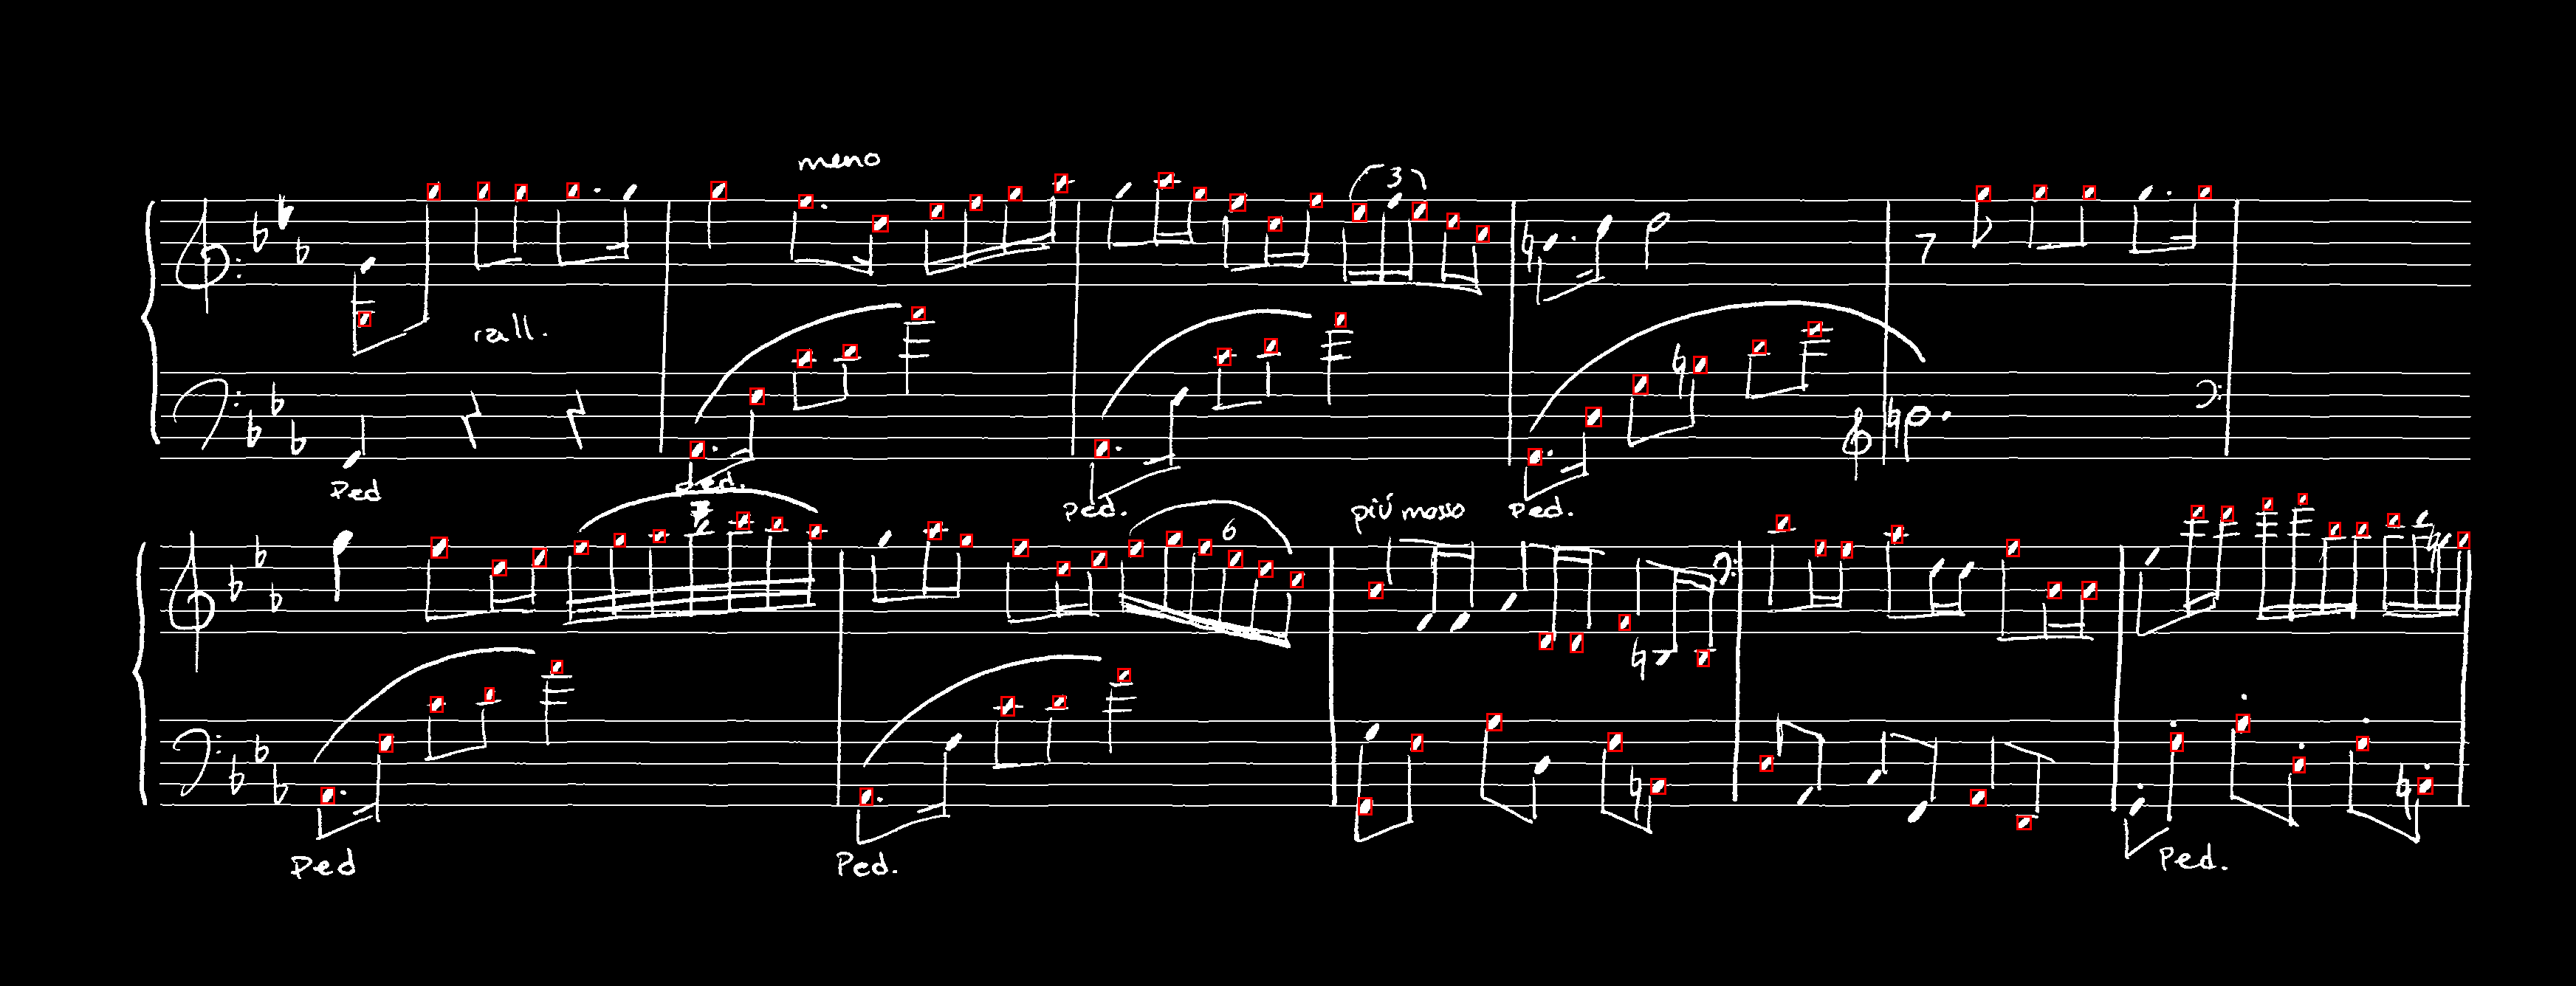

In [21]:
image_index = 0
model.eval()
if torch.cuda.is_available():
  torch.cuda.synchronize()
#image = list(img.to(torch.device('cuda')) for img in image)
image, target = hacky_dataset[image_index]
image = list(img.to(torch.device('cuda')) for img in image)
detections = model(image)

#model.eval()
#if torch.cuda.is_available():
#  torch.cuda.synchronize()
#image, target = next(iter(data_loader_test))
#image = list(img.to(torch.device('cuda')) for img in image)
#detections = model(image)
visualize_bboxes(image[0], detections[0], threshold=0)

In [19]:
detections[0]['boxes'].shape
#torch.sum(detections[0]['labels']==1)

torch.Size([102, 4])

In [22]:
# Example save everything
SAVE_ENTIRE_MODEL = "all_objects_0151.pt"

torch.save(model, SAVE_ENTIRE_MODEL)

In [ ]:
# 15 epochs, Adam, lr=0.001, *0.1 every 5 epochs, 0.135 mAP with custom aspect ratios
# 15 epochs, Adam, lr=0.001, *0.1 every 5 epochs, 0.113 mAP with default aspect ratios
# 50 epochs, Adam, Lr=0.001, *0.1 every 10 epochs, 0.146 mAP with custom aspect ratios